<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/cwiczenia_4a_regression_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.



In [60]:

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt



**1-dimensional data**

In [61]:
def funct(x):
  return x*x*np.sin(x)+np.log(2*x)

size = 100
low=0
high=12
error=10

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(100,) (100,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

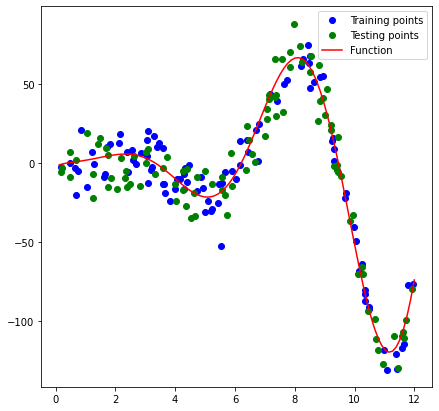

In [62]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show


**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [63]:
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

XX_test_n = XX_test - mean
XX_test_n /= std

meany = yy_train.mean(axis=0)
yy_train_n = yy_train - meany
stdy = yy_train_n.std(axis=0)
yy_train_n /= stdy

yy_test_n = yy_test - meany
yy_test_n /= stdy



#XX_train_n = XX_train_n.reshape((len(XX_train_n),1))
#XX_test_n  = XX_test_n.reshape((len(XX_test_n),1))


In [64]:
! pip install optuna

import optuna

Define objective

In [65]:
def objective(trial):


    units = int(trial.suggest_discrete_uniform("units1", 32,1024,1))
    dropout = trial.suggest_uniform('dropout1', .00,.50)
    act = trial.suggest_categorical('activation', ['relu','sigmoid','linear'])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    epochs = int(trial.suggest_discrete_uniform('epochs', 10,100,1))

    model0 = Sequential(name='network')
    model0.add(Dense(units, input_shape = (1,), activation = act))
    model0.add(Dropout(dropout))
    model0.add(Dense(units, input_shape = (1,), activation = act))
    model0.add(Dropout(dropout))
    model0.add(Dense(1,activation='linear'))

    #sgd0 = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer


    model0.compile(optimizer = optimizers.Adam(lr=lr), loss = 'mean_squared_error', metrics = ['mse'])    # for regression problems, mean squared error (MSE) is often employed
    history = model0.fit(XX_train_n, yy_train_n, batch_size = 128, epochs = epochs, validation_data=(XX_test_n, yy_test_n), verbose = 1 )


    # Evaluate the model accuracy on the validation set.
    score = model0.evaluate(XX_test_n, yy_test_n, verbose=0)
    return score[1]

# Find the best parameters

In [66]:


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)


[I 2020-12-05 22:43:57,964] A new study created in memory with name: no-name-67b8f257-377e-40fc-955c-a47ee36f4496


Epoch 1/24
1/1 [==============================] - 0s 90ms/step - loss: 1.1328 - mse: 1.1328 - val_loss: 83.5648 - val_mse: 83.5648
Epoch 2/24
1/1 [==============================] - 0s 15ms/step - loss: 81.2663 - mse: 81.2663 - val_loss: 8.3239 - val_mse: 8.3239
Epoch 3/24
1/1 [==============================] - 0s 14ms/step - loss: 7.6807 - mse: 7.6807 - val_loss: 24.4021 - val_mse: 24.4021
Epoch 4/24
1/1 [==============================] - 0s 14ms/step - loss: 25.0099 - mse: 25.0099 - val_loss: 37.8611 - val_mse: 37.8611
Epoch 5/24
1/1 [==============================] - 0s 14ms/step - loss: 38.6038 - mse: 38.6038 - val_loss: 20.7808 - val_mse: 20.7808
Epoch 6/24
1/1 [==============================] - 0s 14ms/step - loss: 21.4540 - mse: 21.4540 - val_loss: 4.2503 - val_mse: 4.2503
Epoch 7/24
1/1 [==============================] - 0s 16ms/step - loss: 4.5411 - mse: 4.5411 - val_loss: 1.7328 - val_mse: 1.7328
Epoch 8/24
1/1 [==============================] - 0s 16ms/step - loss: 1.5400 - m

[I 2020-12-05 22:43:58,977] Trial 0 finished with value: 1.1724674701690674 and parameters: {'units1': 519.0, 'dropout1': 0.11781073633091066, 'activation': 'sigmoid', 'lr': 0.00513036987015119, 'epochs': 24.0}. Best is trial 0 with value: 1.1724674701690674.


Epoch 1/22
1/1 [==============================] - 0s 97ms/step - loss: 1.2905 - mse: 1.2905 - val_loss: 163.3396 - val_mse: 163.3396
Epoch 2/22
1/1 [==============================] - 0s 16ms/step - loss: 161.0587 - mse: 161.0587 - val_loss: 42.7178 - val_mse: 42.7178
Epoch 3/22
1/1 [==============================] - 0s 15ms/step - loss: 40.9643 - mse: 40.9643 - val_loss: 36.6036 - val_mse: 36.6036
Epoch 4/22
1/1 [==============================] - 0s 15ms/step - loss: 37.2638 - mse: 37.2638 - val_loss: 31.0960 - val_mse: 31.0960
Epoch 5/22
1/1 [==============================] - 0s 17ms/step - loss: 31.5504 - mse: 31.5504 - val_loss: 9.3876 - val_mse: 9.3876
Epoch 6/22
1/1 [==============================] - 0s 15ms/step - loss: 9.7093 - mse: 9.7093 - val_loss: 1.9816 - val_mse: 1.9816
Epoch 7/22
1/1 [==============================] - 0s 16ms/step - loss: 1.9504 - mse: 1.9504 - val_loss: 1.1817 - val_mse: 1.1817
Epoch 8/22
1/1 [==============================] - 0s 15ms/step - loss: 1.0509

[I 2020-12-05 22:44:00,008] Trial 1 finished with value: 1.3772462606430054 and parameters: {'units1': 382.0, 'dropout1': 0.08598014590552877, 'activation': 'sigmoid', 'lr': 0.015316947251494092, 'epochs': 22.0}. Best is trial 0 with value: 1.1724674701690674.


Epoch 1/24
1/1 [==============================] - 0s 88ms/step - loss: 2.5856 - mse: 2.5856 - val_loss: 2.7643 - val_mse: 2.7643
Epoch 2/24
1/1 [==============================] - 0s 19ms/step - loss: 2.3635 - mse: 2.3635 - val_loss: 2.6181 - val_mse: 2.6181
Epoch 3/24
1/1 [==============================] - 0s 15ms/step - loss: 2.3145 - mse: 2.3145 - val_loss: 2.4792 - val_mse: 2.4792
Epoch 4/24
1/1 [==============================] - 0s 16ms/step - loss: 2.1560 - mse: 2.1560 - val_loss: 2.3481 - val_mse: 2.3481
Epoch 5/24
1/1 [==============================] - 0s 14ms/step - loss: 2.0454 - mse: 2.0454 - val_loss: 2.2244 - val_mse: 2.2244
Epoch 6/24
1/1 [==============================] - 0s 14ms/step - loss: 1.9247 - mse: 1.9247 - val_loss: 2.1085 - val_mse: 2.1085
Epoch 7/24
1/1 [==============================] - 0s 14ms/step - loss: 1.7923 - mse: 1.7923 - val_loss: 2.0002 - val_mse: 2.0002
Epoch 8/24
1/1 [==============================] - 0s 14ms/step - loss: 1.7456 - mse: 1.7456 - val

[I 2020-12-05 22:44:01,311] Trial 2 finished with value: 1.177126407623291 and parameters: {'units1': 825.0, 'dropout1': 0.04092843012426789, 'activation': 'sigmoid', 'lr': 1.5210460384386474e-05, 'epochs': 24.0}. Best is trial 0 with value: 1.1724674701690674.


Epoch 1/18
1/1 [==============================] - 0s 89ms/step - loss: 1.0155 - mse: 1.0155 - val_loss: 1.1687 - val_mse: 1.1687
Epoch 2/18
1/1 [==============================] - 0s 14ms/step - loss: 1.0033 - mse: 1.0033 - val_loss: 1.1597 - val_mse: 1.1597
Epoch 3/18
1/1 [==============================] - 0s 19ms/step - loss: 0.9899 - mse: 0.9899 - val_loss: 1.1515 - val_mse: 1.1515
Epoch 4/18
1/1 [==============================] - 0s 14ms/step - loss: 0.9733 - mse: 0.9733 - val_loss: 1.1439 - val_mse: 1.1439
Epoch 5/18
1/1 [==============================] - 0s 14ms/step - loss: 0.9688 - mse: 0.9688 - val_loss: 1.1370 - val_mse: 1.1370
Epoch 6/18
1/1 [==============================] - 0s 14ms/step - loss: 0.9579 - mse: 0.9579 - val_loss: 1.1306 - val_mse: 1.1306
Epoch 7/18
1/1 [==============================] - 0s 14ms/step - loss: 0.9471 - mse: 0.9471 - val_loss: 1.1247 - val_mse: 1.1247
Epoch 8/18
1/1 [==============================] - 0s 14ms/step - loss: 0.9542 - mse: 0.9542 - val

[I 2020-12-05 22:44:02,168] Trial 3 finished with value: 1.0840028524398804 and parameters: {'units1': 900.0, 'dropout1': 0.20303674825059242, 'activation': 'relu', 'lr': 4.423152096256756e-05, 'epochs': 18.0}. Best is trial 3 with value: 1.0840028524398804.


Epoch 1/37
1/1 [==============================] - 0s 94ms/step - loss: 1.0353 - mse: 1.0353 - val_loss: 50.9735 - val_mse: 50.9735
Epoch 2/37
1/1 [==============================] - 0s 15ms/step - loss: 51.9473 - mse: 51.9473 - val_loss: 1.5541 - val_mse: 1.5541
Epoch 3/37
1/1 [==============================] - 0s 15ms/step - loss: 1.4253 - mse: 1.4253 - val_loss: 4.1391 - val_mse: 4.1391
Epoch 4/37
1/1 [==============================] - 0s 14ms/step - loss: 4.5909 - mse: 4.5909 - val_loss: 1.3847 - val_mse: 1.3847
Epoch 5/37
1/1 [==============================] - 0s 14ms/step - loss: 1.4526 - mse: 1.4526 - val_loss: 2.5223 - val_mse: 2.5223
Epoch 6/37
1/1 [==============================] - 0s 14ms/step - loss: 2.2519 - mse: 2.2519 - val_loss: 2.6003 - val_mse: 2.6003
Epoch 7/37
1/1 [==============================] - 0s 15ms/step - loss: 2.9120 - mse: 2.9120 - val_loss: 1.9173 - val_mse: 1.9173
Epoch 8/37
1/1 [==============================] - 0s 14ms/step - loss: 2.1984 - mse: 2.1984 -

[I 2020-12-05 22:44:03,438] Trial 4 finished with value: 1.1062555313110352 and parameters: {'units1': 71.0, 'dropout1': 0.3765751448430831, 'activation': 'linear', 'lr': 0.0730311792476016, 'epochs': 37.0}. Best is trial 3 with value: 1.0840028524398804.


Epoch 1/25
1/1 [==============================] - 0s 100ms/step - loss: 0.9032 - mse: 0.9032 - val_loss: 1.2736 - val_mse: 1.2736
Epoch 2/25
1/1 [==============================] - 0s 16ms/step - loss: 0.9515 - mse: 0.9515 - val_loss: 1.2022 - val_mse: 1.2022
Epoch 3/25
1/1 [==============================] - 0s 16ms/step - loss: 0.8743 - mse: 0.8743 - val_loss: 1.0859 - val_mse: 1.0859
Epoch 4/25
1/1 [==============================] - 0s 14ms/step - loss: 0.8388 - mse: 0.8388 - val_loss: 1.0826 - val_mse: 1.0826
Epoch 5/25
1/1 [==============================] - 0s 14ms/step - loss: 0.9176 - mse: 0.9176 - val_loss: 1.0851 - val_mse: 1.0851
Epoch 6/25
1/1 [==============================] - 0s 14ms/step - loss: 0.9035 - mse: 0.9035 - val_loss: 1.0753 - val_mse: 1.0753
Epoch 7/25
1/1 [==============================] - 0s 14ms/step - loss: 0.9033 - mse: 0.9033 - val_loss: 1.0942 - val_mse: 1.0942
Epoch 8/25
1/1 [==============================] - 0s 15ms/step - loss: 0.8737 - mse: 0.8737 - va

[I 2020-12-05 22:44:04,436] Trial 5 finished with value: 1.0809534788131714 and parameters: {'units1': 592.0, 'dropout1': 0.4414346089125671, 'activation': 'linear', 'lr': 0.0007410113371059181, 'epochs': 25.0}. Best is trial 5 with value: 1.0809534788131714.


Epoch 1/91
1/1 [==============================] - 0s 94ms/step - loss: 1.8692 - mse: 1.8692 - val_loss: 1.5198 - val_mse: 1.5198
Epoch 2/91
1/1 [==============================] - 0s 14ms/step - loss: 1.7645 - mse: 1.7645 - val_loss: 1.3445 - val_mse: 1.3445
Epoch 3/91
1/1 [==============================] - 0s 14ms/step - loss: 1.5854 - mse: 1.5854 - val_loss: 1.2285 - val_mse: 1.2285
Epoch 4/91
1/1 [==============================] - 0s 15ms/step - loss: 1.4030 - mse: 1.4030 - val_loss: 1.1649 - val_mse: 1.1649
Epoch 5/91
1/1 [==============================] - 0s 16ms/step - loss: 1.2804 - mse: 1.2804 - val_loss: 1.1461 - val_mse: 1.1461
Epoch 6/91
1/1 [==============================] - 0s 16ms/step - loss: 1.8993 - mse: 1.8993 - val_loss: 1.1548 - val_mse: 1.1548
Epoch 7/91
1/1 [==============================] - 0s 16ms/step - loss: 1.4562 - mse: 1.4562 - val_loss: 1.1752 - val_mse: 1.1752
Epoch 8/91
1/1 [==============================] - 0s 16ms/step - loss: 1.7429 - mse: 1.7429 - val

[I 2020-12-05 22:44:06,977] Trial 6 finished with value: 1.1180514097213745 and parameters: {'units1': 60.0, 'dropout1': 0.4785757754413909, 'activation': 'sigmoid', 'lr': 0.0017108827853883034, 'epochs': 91.0}. Best is trial 5 with value: 1.0809534788131714.


Epoch 1/23
1/1 [==============================] - 0s 88ms/step - loss: 0.9856 - mse: 0.9856 - val_loss: 1.1204 - val_mse: 1.1204
Epoch 2/23
1/1 [==============================] - 0s 15ms/step - loss: 0.9274 - mse: 0.9274 - val_loss: 1.0950 - val_mse: 1.0950
Epoch 3/23
1/1 [==============================] - 0s 13ms/step - loss: 0.9155 - mse: 0.9155 - val_loss: 1.0783 - val_mse: 1.0783
Epoch 4/23
1/1 [==============================] - 0s 14ms/step - loss: 0.8747 - mse: 0.8747 - val_loss: 1.0688 - val_mse: 1.0688
Epoch 5/23
1/1 [==============================] - 0s 15ms/step - loss: 0.8560 - mse: 0.8560 - val_loss: 1.0647 - val_mse: 1.0647
Epoch 6/23
1/1 [==============================] - 0s 14ms/step - loss: 0.8333 - mse: 0.8333 - val_loss: 1.0640 - val_mse: 1.0640
Epoch 7/23
1/1 [==============================] - 0s 15ms/step - loss: 0.8143 - mse: 0.8143 - val_loss: 1.0651 - val_mse: 1.0651
Epoch 8/23
1/1 [==============================] - 0s 14ms/step - loss: 0.8184 - mse: 0.8184 - val

[I 2020-12-05 22:44:07,960] Trial 7 finished with value: 1.026708722114563 and parameters: {'units1': 654.0, 'dropout1': 0.12409287301021504, 'activation': 'relu', 'lr': 0.000221740807888133, 'epochs': 23.0}. Best is trial 7 with value: 1.026708722114563.


Epoch 1/60
1/1 [==============================] - 0s 86ms/step - loss: 0.8983 - mse: 0.8983 - val_loss: 6.5621 - val_mse: 6.5621
Epoch 2/60
1/1 [==============================] - 0s 14ms/step - loss: 5.7124 - mse: 5.7124 - val_loss: 1.3672 - val_mse: 1.3672
Epoch 3/60
1/1 [==============================] - 0s 14ms/step - loss: 1.2028 - mse: 1.2028 - val_loss: 3.1512 - val_mse: 3.1512
Epoch 4/60
1/1 [==============================] - 0s 14ms/step - loss: 3.2043 - mse: 3.2043 - val_loss: 2.0864 - val_mse: 2.0864
Epoch 5/60
1/1 [==============================] - 0s 14ms/step - loss: 2.2076 - mse: 2.2076 - val_loss: 1.1522 - val_mse: 1.1522
Epoch 6/60
1/1 [==============================] - 0s 14ms/step - loss: 1.0399 - mse: 1.0399 - val_loss: 1.3159 - val_mse: 1.3159
Epoch 7/60
1/1 [==============================] - 0s 14ms/step - loss: 1.0698 - mse: 1.0698 - val_loss: 1.7224 - val_mse: 1.7224
Epoch 8/60
1/1 [==============================] - 0s 14ms/step - loss: 1.3025 - mse: 1.3025 - val

[I 2020-12-05 22:44:09,761] Trial 8 finished with value: 1.105602502822876 and parameters: {'units1': 195.0, 'dropout1': 0.484544578029707, 'activation': 'linear', 'lr': 0.014117415953384352, 'epochs': 60.0}. Best is trial 7 with value: 1.026708722114563.


Epoch 1/34
1/1 [==============================] - 0s 90ms/step - loss: 0.9907 - mse: 0.9907 - val_loss: 15.1624 - val_mse: 15.1624
Epoch 2/34
1/1 [==============================] - 0s 15ms/step - loss: 12.9835 - mse: 12.9835 - val_loss: 1.0803 - val_mse: 1.0803
Epoch 3/34
1/1 [==============================] - 0s 14ms/step - loss: 0.9601 - mse: 0.9601 - val_loss: 1.5933 - val_mse: 1.5933
Epoch 4/34
1/1 [==============================] - 0s 14ms/step - loss: 1.5110 - mse: 1.5110 - val_loss: 1.3827 - val_mse: 1.3827
Epoch 5/34
1/1 [==============================] - 0s 14ms/step - loss: 1.2677 - mse: 1.2677 - val_loss: 1.2424 - val_mse: 1.2424
Epoch 6/34
1/1 [==============================] - 0s 16ms/step - loss: 1.0976 - mse: 1.0976 - val_loss: 1.1640 - val_mse: 1.1640
Epoch 7/34
1/1 [==============================] - 0s 14ms/step - loss: 1.0041 - mse: 1.0041 - val_loss: 1.1254 - val_mse: 1.1254
Epoch 8/34
1/1 [==============================] - 0s 14ms/step - loss: 0.9712 - mse: 0.9712 -

[I 2020-12-05 22:44:10,971] Trial 9 finished with value: 0.15562450885772705 and parameters: {'units1': 722.0, 'dropout1': 0.31415260371182735, 'activation': 'relu', 'lr': 0.01670817345574373, 'epochs': 34.0}. Best is trial 9 with value: 0.15562450885772705.


Epoch 1/58
1/1 [==============================] - 0s 99ms/step - loss: 1.0016 - mse: 1.0016 - val_loss: 9374.8711 - val_mse: 9374.8711
Epoch 2/58
1/1 [==============================] - 0s 14ms/step - loss: 8418.4365 - mse: 8418.4365 - val_loss: 19783.8574 - val_mse: 19783.8574
Epoch 3/58
1/1 [==============================] - 0s 15ms/step - loss: 21736.6953 - mse: 21736.6953 - val_loss: 31929.4453 - val_mse: 31929.4453
Epoch 4/58
1/1 [==============================] - 0s 14ms/step - loss: 28939.9023 - mse: 28939.9023 - val_loss: 1430.1791 - val_mse: 1430.1791
Epoch 5/58
1/1 [==============================] - 0s 14ms/step - loss: 1504.6434 - mse: 1504.6434 - val_loss: 333.4794 - val_mse: 333.4794
Epoch 6/58
1/1 [==============================] - 0s 14ms/step - loss: 332.2379 - mse: 332.2379 - val_loss: 121.1228 - val_mse: 121.1228
Epoch 7/58
1/1 [==============================] - 0s 15ms/step - loss: 109.8018 - mse: 109.8018 - val_loss: 78.3417 - val_mse: 78.3417
Epoch 8/58
1/1 [=======

[I 2020-12-05 22:44:12,702] Trial 10 finished with value: 0.5948045253753662 and parameters: {'units1': 991.0, 'dropout1': 0.33378993785646277, 'activation': 'relu', 'lr': 0.09566317744105407, 'epochs': 58.0}. Best is trial 9 with value: 0.15562450885772705.


Epoch 1/59
1/1 [==============================] - 0s 88ms/step - loss: 0.9811 - mse: 0.9811 - val_loss: 15960.4775 - val_mse: 15960.4775
Epoch 2/59
1/1 [==============================] - 0s 15ms/step - loss: 14655.4297 - mse: 14655.4297 - val_loss: 27258.7930 - val_mse: 27258.7930
Epoch 3/59
1/1 [==============================] - 0s 14ms/step - loss: 30418.7207 - mse: 30418.7207 - val_loss: 23630.7676 - val_mse: 23630.7676
Epoch 4/59
1/1 [==============================] - 0s 15ms/step - loss: 24070.1270 - mse: 24070.1270 - val_loss: 3520.6477 - val_mse: 3520.6477
Epoch 5/59
1/1 [==============================] - 0s 14ms/step - loss: 3537.9998 - mse: 3537.9998 - val_loss: 552.4001 - val_mse: 552.4001
Epoch 6/59
1/1 [==============================] - 0s 14ms/step - loss: 542.3013 - mse: 542.3013 - val_loss: 92.7613 - val_mse: 92.7613
Epoch 7/59
1/1 [==============================] - 0s 14ms/step - loss: 109.1147 - mse: 109.1147 - val_loss: 166.0192 - val_mse: 166.0192
Epoch 8/59
1/1 [===

[I 2020-12-05 22:44:14,417] Trial 11 finished with value: 0.4148518443107605 and parameters: {'units1': 1006.0, 'dropout1': 0.3092145585198645, 'activation': 'relu', 'lr': 0.0952950999497688, 'epochs': 59.0}. Best is trial 9 with value: 0.15562450885772705.


Epoch 1/78
1/1 [==============================] - 0s 87ms/step - loss: 0.9908 - mse: 0.9908 - val_loss: 237.9561 - val_mse: 237.9561
Epoch 2/78
1/1 [==============================] - 0s 13ms/step - loss: 223.2562 - mse: 223.2562 - val_loss: 23.8078 - val_mse: 23.8078
Epoch 3/78
1/1 [==============================] - 0s 15ms/step - loss: 23.9543 - mse: 23.9543 - val_loss: 1.7030 - val_mse: 1.7030
Epoch 4/78
1/1 [==============================] - 0s 14ms/step - loss: 1.2268 - mse: 1.2268 - val_loss: 11.1014 - val_mse: 11.1014
Epoch 5/78
1/1 [==============================] - 0s 19ms/step - loss: 9.1293 - mse: 9.1293 - val_loss: 3.6220 - val_mse: 3.6220
Epoch 6/78
1/1 [==============================] - 0s 14ms/step - loss: 2.8602 - mse: 2.8602 - val_loss: 1.4531 - val_mse: 1.4531
Epoch 7/78
1/1 [==============================] - 0s 18ms/step - loss: 1.1778 - mse: 1.1778 - val_loss: 2.0788 - val_mse: 2.0788
Epoch 8/78
1/1 [==============================] - 0s 16ms/step - loss: 2.0594 - mse

[I 2020-12-05 22:44:16,556] Trial 12 finished with value: 0.09440983086824417 and parameters: {'units1': 764.0, 'dropout1': 0.27898551165853164, 'activation': 'relu', 'lr': 0.04213383133578633, 'epochs': 78.0}. Best is trial 12 with value: 0.09440983086824417.


Epoch 1/84
1/1 [==============================] - 0s 94ms/step - loss: 0.9793 - mse: 0.9793 - val_loss: 41.3971 - val_mse: 41.3971
Epoch 2/84
1/1 [==============================] - 0s 14ms/step - loss: 37.6180 - mse: 37.6180 - val_loss: 2.2211 - val_mse: 2.2211
Epoch 3/84
1/1 [==============================] - 0s 14ms/step - loss: 2.1232 - mse: 2.1232 - val_loss: 2.3769 - val_mse: 2.3769
Epoch 4/84
1/1 [==============================] - 0s 14ms/step - loss: 2.3200 - mse: 2.3200 - val_loss: 1.5949 - val_mse: 1.5949
Epoch 5/84
1/1 [==============================] - 0s 14ms/step - loss: 1.4643 - mse: 1.4643 - val_loss: 1.2530 - val_mse: 1.2530
Epoch 6/84
1/1 [==============================] - 0s 14ms/step - loss: 1.0811 - mse: 1.0811 - val_loss: 1.0852 - val_mse: 1.0852
Epoch 7/84
1/1 [==============================] - 0s 17ms/step - loss: 0.9070 - mse: 0.9070 - val_loss: 0.9008 - val_mse: 0.9008
Epoch 8/84
1/1 [==============================] - 0s 15ms/step - loss: 0.7158 - mse: 0.7158 -

[I 2020-12-05 22:44:18,865] Trial 13 finished with value: 0.08151265978813171 and parameters: {'units1': 730.0, 'dropout1': 0.22438628333305347, 'activation': 'relu', 'lr': 0.023838585700141482, 'epochs': 84.0}. Best is trial 13 with value: 0.08151265978813171.


Epoch 1/90
1/1 [==============================] - 0s 86ms/step - loss: 0.9958 - mse: 0.9958 - val_loss: 74.5328 - val_mse: 74.5328
Epoch 2/90
1/1 [==============================] - 0s 14ms/step - loss: 69.2617 - mse: 69.2617 - val_loss: 5.6362 - val_mse: 5.6362
Epoch 3/90
1/1 [==============================] - 0s 14ms/step - loss: 5.7251 - mse: 5.7251 - val_loss: 2.8784 - val_mse: 2.8784
Epoch 4/90
1/1 [==============================] - 0s 14ms/step - loss: 2.8625 - mse: 2.8625 - val_loss: 1.3808 - val_mse: 1.3808
Epoch 5/90
1/1 [==============================] - 0s 15ms/step - loss: 1.1835 - mse: 1.1835 - val_loss: 1.0353 - val_mse: 1.0353
Epoch 6/90
1/1 [==============================] - 0s 15ms/step - loss: 0.8217 - mse: 0.8217 - val_loss: 0.9297 - val_mse: 0.9297
Epoch 7/90
1/1 [==============================] - 0s 14ms/step - loss: 0.6921 - mse: 0.6921 - val_loss: 0.8384 - val_mse: 0.8384
Epoch 8/90
1/1 [==============================] - 0s 14ms/step - loss: 0.5985 - mse: 0.5985 -

[I 2020-12-05 22:44:21,234] Trial 14 finished with value: 0.08416721224784851 and parameters: {'units1': 801.0, 'dropout1': 0.21631465430024016, 'activation': 'relu', 'lr': 0.028975863524902133, 'epochs': 90.0}. Best is trial 13 with value: 0.08151265978813171.


Epoch 1/100
1/1 [==============================] - 0s 92ms/step - loss: 1.0087 - mse: 1.0087 - val_loss: 1.1470 - val_mse: 1.1470
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 0.8576 - mse: 0.8576 - val_loss: 1.1614 - val_mse: 1.1614
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.8377 - mse: 0.8377 - val_loss: 1.0736 - val_mse: 1.0736
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7826 - mse: 0.7826 - val_loss: 0.9951 - val_mse: 0.9951
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 0.7709 - mse: 0.7709 - val_loss: 0.9468 - val_mse: 0.9468
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7406 - mse: 0.7406 - val_loss: 0.9111 - val_mse: 0.9111
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 0.7149 - mse: 0.7149 - val_loss: 0.8735 - val_mse: 0.8735
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.7076 - mse: 0.70

[I 2020-12-05 22:44:23,971] Trial 15 finished with value: 0.12048706412315369 and parameters: {'units1': 466.0, 'dropout1': 0.20477005334961476, 'activation': 'relu', 'lr': 0.0034813209293184924, 'epochs': 100.0}. Best is trial 13 with value: 0.08151265978813171.


Epoch 1/76
1/1 [==============================] - 0s 87ms/step - loss: 1.0152 - mse: 1.0152 - val_loss: 81.6079 - val_mse: 81.6079
Epoch 2/76
1/1 [==============================] - 0s 14ms/step - loss: 74.2073 - mse: 74.2073 - val_loss: 5.4319 - val_mse: 5.4319
Epoch 3/76
1/1 [==============================] - 0s 14ms/step - loss: 5.3926 - mse: 5.3926 - val_loss: 3.1177 - val_mse: 3.1177
Epoch 4/76
1/1 [==============================] - 0s 14ms/step - loss: 2.9833 - mse: 2.9833 - val_loss: 1.4794 - val_mse: 1.4794
Epoch 5/76
1/1 [==============================] - 0s 14ms/step - loss: 1.3134 - mse: 1.3134 - val_loss: 1.1490 - val_mse: 1.1490
Epoch 6/76
1/1 [==============================] - 0s 14ms/step - loss: 0.9292 - mse: 0.9292 - val_loss: 0.9050 - val_mse: 0.9050
Epoch 7/76
1/1 [==============================] - 0s 14ms/step - loss: 0.6757 - mse: 0.6757 - val_loss: 1.2927 - val_mse: 1.2927
Epoch 8/76
1/1 [==============================] - 0s 15ms/step - loss: 1.1094 - mse: 1.1094 -

[I 2020-12-05 22:44:26,050] Trial 16 finished with value: 0.078288733959198 and parameters: {'units1': 862.0, 'dropout1': 0.2001873909290413, 'activation': 'relu', 'lr': 0.02749787521431682, 'epochs': 76.0}. Best is trial 16 with value: 0.078288733959198.


Epoch 1/73
1/1 [==============================] - 0s 91ms/step - loss: 0.9998 - mse: 0.9998 - val_loss: 2.6925 - val_mse: 2.6925
Epoch 2/73
1/1 [==============================] - 0s 15ms/step - loss: 2.1567 - mse: 2.1567 - val_loss: 1.0982 - val_mse: 1.0982
Epoch 3/73
1/1 [==============================] - 0s 14ms/step - loss: 0.8102 - mse: 0.8102 - val_loss: 1.0890 - val_mse: 1.0890
Epoch 4/73
1/1 [==============================] - 0s 15ms/step - loss: 0.8988 - mse: 0.8988 - val_loss: 1.1006 - val_mse: 1.1006
Epoch 5/73
1/1 [==============================] - 0s 15ms/step - loss: 0.9463 - mse: 0.9463 - val_loss: 1.0489 - val_mse: 1.0489
Epoch 6/73
1/1 [==============================] - 0s 15ms/step - loss: 0.8816 - mse: 0.8816 - val_loss: 0.9880 - val_mse: 0.9880
Epoch 7/73
1/1 [==============================] - 0s 16ms/step - loss: 0.8186 - mse: 0.8186 - val_loss: 0.9311 - val_mse: 0.9311
Epoch 8/73
1/1 [==============================] - 0s 15ms/step - loss: 0.7628 - mse: 0.7628 - val

[I 2020-12-05 22:44:28,078] Trial 17 finished with value: 0.0971539318561554 and parameters: {'units1': 914.0, 'dropout1': 0.15357654305453242, 'activation': 'relu', 'lr': 0.0049007782052007025, 'epochs': 73.0}. Best is trial 16 with value: 0.078288733959198.


Epoch 1/76
1/1 [==============================] - 0s 87ms/step - loss: 0.9716 - mse: 0.9716 - val_loss: 1.1012 - val_mse: 1.1012
Epoch 2/76
1/1 [==============================] - 0s 15ms/step - loss: 0.9093 - mse: 0.9093 - val_loss: 1.0756 - val_mse: 1.0756
Epoch 3/76
1/1 [==============================] - 0s 15ms/step - loss: 0.8648 - mse: 0.8648 - val_loss: 1.0639 - val_mse: 1.0639
Epoch 4/76
1/1 [==============================] - 0s 15ms/step - loss: 0.8366 - mse: 0.8366 - val_loss: 1.0613 - val_mse: 1.0613
Epoch 5/76
1/1 [==============================] - 0s 14ms/step - loss: 0.8172 - mse: 0.8172 - val_loss: 1.0632 - val_mse: 1.0632
Epoch 6/76
1/1 [==============================] - 0s 14ms/step - loss: 0.8101 - mse: 0.8101 - val_loss: 1.0670 - val_mse: 1.0670
Epoch 7/76
1/1 [==============================] - 0s 14ms/step - loss: 0.8003 - mse: 0.8003 - val_loss: 1.0707 - val_mse: 1.0707
Epoch 8/76
1/1 [==============================] - 0s 15ms/step - loss: 0.7970 - mse: 0.7970 - val

[I 2020-12-05 22:44:30,235] Trial 18 finished with value: 0.2463393211364746 and parameters: {'units1': 667.0, 'dropout1': 0.012624912419802597, 'activation': 'relu', 'lr': 0.00035844562641966835, 'epochs': 76.0}. Best is trial 16 with value: 0.078288733959198.


Epoch 1/87
1/1 [==============================] - 0s 93ms/step - loss: 1.0148 - mse: 1.0148 - val_loss: 4.6457 - val_mse: 4.6457
Epoch 2/87
1/1 [==============================] - 0s 14ms/step - loss: 3.9688 - mse: 3.9688 - val_loss: 1.0451 - val_mse: 1.0451
Epoch 3/87
1/1 [==============================] - 0s 14ms/step - loss: 0.8033 - mse: 0.8033 - val_loss: 1.2680 - val_mse: 1.2680
Epoch 4/87
1/1 [==============================] - 0s 14ms/step - loss: 1.1229 - mse: 1.1229 - val_loss: 1.2592 - val_mse: 1.2592
Epoch 5/87
1/1 [==============================] - 0s 14ms/step - loss: 1.0993 - mse: 1.0993 - val_loss: 1.1934 - val_mse: 1.1934
Epoch 6/87
1/1 [==============================] - 0s 17ms/step - loss: 1.0472 - mse: 1.0472 - val_loss: 1.1296 - val_mse: 1.1296
Epoch 7/87
1/1 [==============================] - 0s 21ms/step - loss: 0.9710 - mse: 0.9710 - val_loss: 1.0717 - val_mse: 1.0717
Epoch 8/87
1/1 [==============================] - 0s 14ms/step - loss: 0.9053 - mse: 0.9053 - val

[I 2020-12-05 22:44:32,605] Trial 19 finished with value: 0.12704403698444366 and parameters: {'units1': 892.0, 'dropout1': 0.2506221542513277, 'activation': 'relu', 'lr': 0.007535117299007948, 'epochs': 87.0}. Best is trial 16 with value: 0.078288733959198.


Epoch 1/68
1/1 [==============================] - 0s 91ms/step - loss: 0.9436 - mse: 0.9436 - val_loss: 1082.5142 - val_mse: 1082.5142
Epoch 2/68
1/1 [==============================] - 0s 16ms/step - loss: 1024.6742 - mse: 1024.6742 - val_loss: 63.7850 - val_mse: 63.7850
Epoch 3/68
1/1 [==============================] - 0s 14ms/step - loss: 60.0622 - mse: 60.0622 - val_loss: 128.9411 - val_mse: 128.9411
Epoch 4/68
1/1 [==============================] - 0s 15ms/step - loss: 137.7221 - mse: 137.7221 - val_loss: 76.8181 - val_mse: 76.8181
Epoch 5/68
1/1 [==============================] - 0s 14ms/step - loss: 65.9586 - mse: 65.9586 - val_loss: 103.8790 - val_mse: 103.8790
Epoch 6/68
1/1 [==============================] - 0s 21ms/step - loss: 112.6752 - mse: 112.6752 - val_loss: 11.2144 - val_mse: 11.2144
Epoch 7/68
1/1 [==============================] - 0s 17ms/step - loss: 11.6546 - mse: 11.6546 - val_loss: 342.6226 - val_mse: 342.6226
Epoch 8/68
1/1 [==============================] - 0s 

[I 2020-12-05 22:44:34,527] Trial 20 finished with value: 1.1765984296798706 and parameters: {'units1': 429.0, 'dropout1': 0.16558268198411033, 'activation': 'linear', 'lr': 0.04535069439624869, 'epochs': 68.0}. Best is trial 16 with value: 0.078288733959198.


Epoch 1/94
1/1 [==============================] - 0s 101ms/step - loss: 1.0222 - mse: 1.0222 - val_loss: 61.6401 - val_mse: 61.6401
Epoch 2/94
1/1 [==============================] - 0s 15ms/step - loss: 56.2272 - mse: 56.2272 - val_loss: 3.3708 - val_mse: 3.3708
Epoch 3/94
1/1 [==============================] - 0s 16ms/step - loss: 3.4071 - mse: 3.4071 - val_loss: 2.6629 - val_mse: 2.6629
Epoch 4/94
1/1 [==============================] - 0s 15ms/step - loss: 2.6088 - mse: 2.6088 - val_loss: 1.6113 - val_mse: 1.6113
Epoch 5/94
1/1 [==============================] - 0s 16ms/step - loss: 1.4200 - mse: 1.4200 - val_loss: 1.2876 - val_mse: 1.2876
Epoch 6/94
1/1 [==============================] - 0s 17ms/step - loss: 1.0641 - mse: 1.0641 - val_loss: 1.1301 - val_mse: 1.1301
Epoch 7/94
1/1 [==============================] - 0s 17ms/step - loss: 0.9118 - mse: 0.9118 - val_loss: 0.9516 - val_mse: 0.9516
Epoch 8/94
1/1 [==============================] - 0s 15ms/step - loss: 0.7348 - mse: 0.7348 

[I 2020-12-05 22:44:37,090] Trial 21 finished with value: 0.0775676965713501 and parameters: {'units1': 804.0, 'dropout1': 0.2126833169136835, 'activation': 'relu', 'lr': 0.0264842800853066, 'epochs': 94.0}. Best is trial 21 with value: 0.0775676965713501.


Epoch 1/96
1/1 [==============================] - 0s 99ms/step - loss: 0.9775 - mse: 0.9775 - val_loss: 88.8370 - val_mse: 88.8370
Epoch 2/96
1/1 [==============================] - 0s 16ms/step - loss: 80.2935 - mse: 80.2935 - val_loss: 4.8366 - val_mse: 4.8366
Epoch 3/96
1/1 [==============================] - 0s 16ms/step - loss: 4.5384 - mse: 4.5384 - val_loss: 3.3876 - val_mse: 3.3876
Epoch 4/96
1/1 [==============================] - 0s 15ms/step - loss: 3.2338 - mse: 3.2338 - val_loss: 1.6624 - val_mse: 1.6624
Epoch 5/96
1/1 [==============================] - 0s 16ms/step - loss: 1.4973 - mse: 1.4973 - val_loss: 1.2618 - val_mse: 1.2618
Epoch 6/96
1/1 [==============================] - 0s 15ms/step - loss: 1.0477 - mse: 1.0477 - val_loss: 1.0597 - val_mse: 1.0597
Epoch 7/96
1/1 [==============================] - 0s 16ms/step - loss: 0.7815 - mse: 0.7815 - val_loss: 1.2149 - val_mse: 1.2149
Epoch 8/96
1/1 [==============================] - 0s 15ms/step - loss: 0.9128 - mse: 0.9128 -

[I 2020-12-05 22:44:39,824] Trial 22 finished with value: 0.07700888067483902 and parameters: {'units1': 1024.0, 'dropout1': 0.26409782239363494, 'activation': 'relu', 'lr': 0.024076891868230022, 'epochs': 96.0}. Best is trial 22 with value: 0.07700888067483902.


Epoch 1/100
1/1 [==============================] - 0s 89ms/step - loss: 0.9799 - mse: 0.9799 - val_loss: 1.2724 - val_mse: 1.2724
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 0.9542 - mse: 0.9542 - val_loss: 1.1891 - val_mse: 1.1891
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 0.8576 - mse: 0.8576 - val_loss: 1.0573 - val_mse: 1.0573
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 0.7930 - mse: 0.7930 - val_loss: 1.0035 - val_mse: 1.0035
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 0.7663 - mse: 0.7663 - val_loss: 0.9780 - val_mse: 0.9780
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7618 - mse: 0.7618 - val_loss: 0.9490 - val_mse: 0.9490
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 0.7668 - mse: 0.7668 - val_loss: 0.9125 - val_mse: 0.9125
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7424 - mse: 0.74

[I 2020-12-05 22:44:43,085] Trial 23 finished with value: 0.10918381065130234 and parameters: {'units1': 998.0, 'dropout1': 0.3836770518154341, 'activation': 'relu', 'lr': 0.0018908718167912396, 'epochs': 100.0}. Best is trial 22 with value: 0.07700888067483902.


Epoch 1/46
1/1 [==============================] - 0s 88ms/step - loss: 1.0039 - mse: 1.0039 - val_loss: 5.9319 - val_mse: 5.9319
Epoch 2/46
1/1 [==============================] - 0s 15ms/step - loss: 5.1264 - mse: 5.1264 - val_loss: 1.0325 - val_mse: 1.0325
Epoch 3/46
1/1 [==============================] - 0s 14ms/step - loss: 0.8058 - mse: 0.8058 - val_loss: 1.2709 - val_mse: 1.2709
Epoch 4/46
1/1 [==============================] - 0s 14ms/step - loss: 1.1165 - mse: 1.1165 - val_loss: 1.2764 - val_mse: 1.2764
Epoch 5/46
1/1 [==============================] - 0s 15ms/step - loss: 1.1185 - mse: 1.1185 - val_loss: 1.2107 - val_mse: 1.2107
Epoch 6/46
1/1 [==============================] - 0s 14ms/step - loss: 1.0512 - mse: 1.0512 - val_loss: 1.1478 - val_mse: 1.1478
Epoch 7/46
1/1 [==============================] - 0s 14ms/step - loss: 0.9794 - mse: 0.9794 - val_loss: 1.0952 - val_mse: 1.0952
Epoch 8/46
1/1 [==============================] - 0s 14ms/step - loss: 0.9284 - mse: 0.9284 - val

[I 2020-12-05 22:44:44,561] Trial 24 finished with value: 0.11964593082666397 and parameters: {'units1': 871.0, 'dropout1': 0.2820993658934596, 'activation': 'relu', 'lr': 0.008715783654326622, 'epochs': 46.0}. Best is trial 22 with value: 0.07700888067483902.


Epoch 1/95
1/1 [==============================] - 0s 90ms/step - loss: 0.9685 - mse: 0.9685 - val_loss: 861.2238 - val_mse: 861.2238
Epoch 2/95
1/1 [==============================] - 0s 14ms/step - loss: 772.0891 - mse: 772.0891 - val_loss: 158.6716 - val_mse: 158.6716
Epoch 3/95
1/1 [==============================] - 0s 14ms/step - loss: 152.9856 - mse: 152.9856 - val_loss: 120.7021 - val_mse: 120.7021
Epoch 4/95
1/1 [==============================] - 0s 14ms/step - loss: 109.2536 - mse: 109.2536 - val_loss: 52.3242 - val_mse: 52.3242
Epoch 5/95
1/1 [==============================] - 0s 14ms/step - loss: 47.0979 - mse: 47.0979 - val_loss: 13.5159 - val_mse: 13.5159
Epoch 6/95
1/1 [==============================] - 0s 13ms/step - loss: 12.1817 - mse: 12.1817 - val_loss: 9.5801 - val_mse: 9.5801
Epoch 7/95
1/1 [==============================] - 0s 15ms/step - loss: 9.5484 - mse: 9.5484 - val_loss: 1.5361 - val_mse: 1.5361
Epoch 8/95
1/1 [==============================] - 0s 16ms/step - 

[I 2020-12-05 22:44:47,088] Trial 25 finished with value: 0.08299344033002853 and parameters: {'units1': 950.0, 'dropout1': 0.16880863628095555, 'activation': 'relu', 'lr': 0.05288926747593009, 'epochs': 95.0}. Best is trial 22 with value: 0.07700888067483902.


Epoch 1/84
1/1 [==============================] - 0s 100ms/step - loss: 0.9929 - mse: 0.9929 - val_loss: 9847.7158 - val_mse: 9847.7158
Epoch 2/84
1/1 [==============================] - 0s 15ms/step - loss: 8881.8496 - mse: 8881.8496 - val_loss: 1748.2014 - val_mse: 1748.2014
Epoch 3/84
1/1 [==============================] - 0s 14ms/step - loss: 1989.2803 - mse: 1989.2803 - val_loss: 38731.7852 - val_mse: 38731.7852
Epoch 4/84
1/1 [==============================] - 0s 14ms/step - loss: 36651.9375 - mse: 36651.9375 - val_loss: 568.2767 - val_mse: 568.2767
Epoch 5/84
1/1 [==============================] - 0s 15ms/step - loss: 572.2346 - mse: 572.2346 - val_loss: 1197.7878 - val_mse: 1197.7878
Epoch 6/84
1/1 [==============================] - 0s 14ms/step - loss: 1091.7515 - mse: 1091.7515 - val_loss: 222.3119 - val_mse: 222.3119
Epoch 7/84
1/1 [==============================] - 0s 14ms/step - loss: 218.9910 - mse: 218.9910 - val_loss: 481.9752 - val_mse: 481.9752
Epoch 8/84
1/1 [========

[I 2020-12-05 22:44:49,461] Trial 26 finished with value: 0.4849897623062134 and parameters: {'units1': 1002.0, 'dropout1': 0.25459132422170944, 'activation': 'relu', 'lr': 0.093079575846472, 'epochs': 84.0}. Best is trial 22 with value: 0.07700888067483902.


Epoch 1/67
1/1 [==============================] - 0s 89ms/step - loss: 1.0411 - mse: 1.0411 - val_loss: 71.9281 - val_mse: 71.9281
Epoch 2/67
1/1 [==============================] - 0s 14ms/step - loss: 62.7924 - mse: 62.7924 - val_loss: 3.4794 - val_mse: 3.4794
Epoch 3/67
1/1 [==============================] - 0s 17ms/step - loss: 3.4815 - mse: 3.4815 - val_loss: 2.9738 - val_mse: 2.9738
Epoch 4/67
1/1 [==============================] - 0s 15ms/step - loss: 2.8977 - mse: 2.8977 - val_loss: 1.6180 - val_mse: 1.6180
Epoch 5/67
1/1 [==============================] - 0s 16ms/step - loss: 1.4659 - mse: 1.4659 - val_loss: 1.2413 - val_mse: 1.2413
Epoch 6/67
1/1 [==============================] - 0s 16ms/step - loss: 1.0343 - mse: 1.0343 - val_loss: 1.0749 - val_mse: 1.0749
Epoch 7/67
1/1 [==============================] - 0s 15ms/step - loss: 0.8274 - mse: 0.8274 - val_loss: 1.0178 - val_mse: 1.0178
Epoch 8/67
1/1 [==============================] - 0s 19ms/step - loss: 0.7341 - mse: 0.7341 -

[I 2020-12-05 22:44:51,366] Trial 27 finished with value: 0.12178841233253479 and parameters: {'units1': 815.0, 'dropout1': 0.35895931359464334, 'activation': 'relu', 'lr': 0.026976747740697107, 'epochs': 67.0}. Best is trial 22 with value: 0.07700888067483902.


Epoch 1/96
1/1 [==============================] - 0s 89ms/step - loss: 1.0309 - mse: 1.0309 - val_loss: 4.2671 - val_mse: 4.2671
Epoch 2/96
1/1 [==============================] - 0s 15ms/step - loss: 3.5871 - mse: 3.5871 - val_loss: 1.0511 - val_mse: 1.0511
Epoch 3/96
1/1 [==============================] - 0s 16ms/step - loss: 0.7983 - mse: 0.7983 - val_loss: 1.2129 - val_mse: 1.2129
Epoch 4/96
1/1 [==============================] - 0s 13ms/step - loss: 1.0710 - mse: 1.0710 - val_loss: 1.1921 - val_mse: 1.1921
Epoch 5/96
1/1 [==============================] - 0s 13ms/step - loss: 1.0412 - mse: 1.0412 - val_loss: 1.1364 - val_mse: 1.1364
Epoch 6/96
1/1 [==============================] - 0s 14ms/step - loss: 0.9817 - mse: 0.9817 - val_loss: 1.0818 - val_mse: 1.0818
Epoch 7/96
1/1 [==============================] - 0s 16ms/step - loss: 0.9228 - mse: 0.9228 - val_loss: 1.0254 - val_mse: 1.0254
Epoch 8/96
1/1 [==============================] - 0s 14ms/step - loss: 0.8632 - mse: 0.8632 - val

[I 2020-12-05 22:44:53,921] Trial 28 finished with value: 0.07304341346025467 and parameters: {'units1': 618.0, 'dropout1': 0.07733801886955924, 'activation': 'relu', 'lr': 0.010340040114396267, 'epochs': 96.0}. Best is trial 28 with value: 0.07304341346025467.


Epoch 1/96
1/1 [==============================] - 0s 89ms/step - loss: 1.0575 - mse: 1.0575 - val_loss: 34.5897 - val_mse: 34.5897
Epoch 2/96
1/1 [==============================] - 0s 17ms/step - loss: 35.3001 - mse: 35.3001 - val_loss: 2.6525 - val_mse: 2.6525
Epoch 3/96
1/1 [==============================] - 0s 14ms/step - loss: 2.7361 - mse: 2.7361 - val_loss: 12.0839 - val_mse: 12.0839
Epoch 4/96
1/1 [==============================] - 0s 14ms/step - loss: 11.3776 - mse: 11.3776 - val_loss: 20.4862 - val_mse: 20.4862
Epoch 5/96
1/1 [==============================] - 0s 15ms/step - loss: 19.6191 - mse: 19.6191 - val_loss: 12.9469 - val_mse: 12.9469
Epoch 6/96
1/1 [==============================] - 0s 14ms/step - loss: 12.0415 - mse: 12.0415 - val_loss: 3.6722 - val_mse: 3.6722
Epoch 7/96
1/1 [==============================] - 0s 14ms/step - loss: 3.2406 - mse: 3.2406 - val_loss: 1.2828 - val_mse: 1.2828
Epoch 8/96
1/1 [==============================] - 0s 14ms/step - loss: 1.2174 - m

[I 2020-12-05 22:44:56,459] Trial 29 finished with value: 1.0759369134902954 and parameters: {'units1': 572.0, 'dropout1': 0.0567715608757287, 'activation': 'sigmoid', 'lr': 0.003021823076053239, 'epochs': 96.0}. Best is trial 28 with value: 0.07304341346025467.


Epoch 1/98
1/1 [==============================] - 0s 89ms/step - loss: 1.0633 - mse: 1.0633 - val_loss: 1.3345 - val_mse: 1.3345
Epoch 2/98
1/1 [==============================] - 0s 15ms/step - loss: 0.9712 - mse: 0.9712 - val_loss: 1.0947 - val_mse: 1.0947
Epoch 3/98
1/1 [==============================] - 0s 15ms/step - loss: 0.8150 - mse: 0.8150 - val_loss: 0.9792 - val_mse: 0.9792
Epoch 4/98
1/1 [==============================] - 0s 16ms/step - loss: 0.7636 - mse: 0.7636 - val_loss: 0.9319 - val_mse: 0.9319
Epoch 5/98
1/1 [==============================] - 0s 14ms/step - loss: 0.7517 - mse: 0.7517 - val_loss: 0.8676 - val_mse: 0.8676
Epoch 6/98
1/1 [==============================] - 0s 14ms/step - loss: 0.6909 - mse: 0.6909 - val_loss: 0.8027 - val_mse: 0.8027
Epoch 7/98
1/1 [==============================] - 0s 18ms/step - loss: 0.6390 - mse: 0.6390 - val_loss: 0.7469 - val_mse: 0.7469
Epoch 8/98
1/1 [==============================] - 0s 15ms/step - loss: 0.5759 - mse: 0.5759 - val

[I 2020-12-05 22:44:59,063] Trial 30 finished with value: 0.10016440600156784 and parameters: {'units1': 271.0, 'dropout1': 0.10882253408292519, 'activation': 'relu', 'lr': 0.008226990257055804, 'epochs': 98.0}. Best is trial 28 with value: 0.07304341346025467.


Epoch 1/81
1/1 [==============================] - 0s 94ms/step - loss: 0.9916 - mse: 0.9916 - val_loss: 6.5930 - val_mse: 6.5930
Epoch 2/81
1/1 [==============================] - 0s 15ms/step - loss: 5.6355 - mse: 5.6355 - val_loss: 0.9989 - val_mse: 0.9989
Epoch 3/81
1/1 [==============================] - 0s 14ms/step - loss: 0.7889 - mse: 0.7889 - val_loss: 1.3696 - val_mse: 1.3696
Epoch 4/81
1/1 [==============================] - 0s 13ms/step - loss: 1.2516 - mse: 1.2516 - val_loss: 1.3218 - val_mse: 1.3218
Epoch 5/81
1/1 [==============================] - 0s 14ms/step - loss: 1.1766 - mse: 1.1766 - val_loss: 1.2470 - val_mse: 1.2470
Epoch 6/81
1/1 [==============================] - 0s 14ms/step - loss: 1.0948 - mse: 1.0948 - val_loss: 1.1879 - val_mse: 1.1879
Epoch 7/81
1/1 [==============================] - 0s 14ms/step - loss: 1.0314 - mse: 1.0314 - val_loss: 1.1440 - val_mse: 1.1440
Epoch 8/81
1/1 [==============================] - 0s 14ms/step - loss: 0.9872 - mse: 0.9872 - val

[I 2020-12-05 22:45:01,299] Trial 31 finished with value: 0.09193876385688782 and parameters: {'units1': 669.0, 'dropout1': 0.1419830820516359, 'activation': 'relu', 'lr': 0.011565182259358802, 'epochs': 81.0}. Best is trial 28 with value: 0.07304341346025467.


Epoch 1/93
1/1 [==============================] - 0s 103ms/step - loss: 1.0095 - mse: 1.0095 - val_loss: 20.1777 - val_mse: 20.1777
Epoch 2/93
1/1 [==============================] - 0s 14ms/step - loss: 18.1624 - mse: 18.1624 - val_loss: 1.3284 - val_mse: 1.3284
Epoch 3/93
1/1 [==============================] - 0s 15ms/step - loss: 1.2301 - mse: 1.2301 - val_loss: 1.7787 - val_mse: 1.7787
Epoch 4/93
1/1 [==============================] - 0s 16ms/step - loss: 1.6635 - mse: 1.6635 - val_loss: 1.4342 - val_mse: 1.4342
Epoch 5/93
1/1 [==============================] - 0s 14ms/step - loss: 1.2804 - mse: 1.2804 - val_loss: 1.2394 - val_mse: 1.2394
Epoch 6/93
1/1 [==============================] - 0s 15ms/step - loss: 1.0775 - mse: 1.0775 - val_loss: 1.1586 - val_mse: 1.1586
Epoch 7/93
1/1 [==============================] - 0s 14ms/step - loss: 0.9925 - mse: 0.9925 - val_loss: 1.1276 - val_mse: 1.1276
Epoch 8/93
1/1 [==============================] - 0s 13ms/step - loss: 0.9565 - mse: 0.9565 

[I 2020-12-05 22:45:03,869] Trial 32 finished with value: 0.08807329088449478 and parameters: {'units1': 522.0, 'dropout1': 0.18445460264517927, 'activation': 'relu', 'lr': 0.024331315560125695, 'epochs': 93.0}. Best is trial 28 with value: 0.07304341346025467.


Epoch 1/88
1/1 [==============================] - 0s 88ms/step - loss: 1.7910 - mse: 1.7910 - val_loss: 205.4910 - val_mse: 205.4910
Epoch 2/88
1/1 [==============================] - 0s 15ms/step - loss: 205.3581 - mse: 205.3581 - val_loss: 30.8702 - val_mse: 30.8702
Epoch 3/88
1/1 [==============================] - 0s 15ms/step - loss: 31.1898 - mse: 31.1898 - val_loss: 66.4581 - val_mse: 66.4581
Epoch 4/88
1/1 [==============================] - 0s 14ms/step - loss: 65.0275 - mse: 65.0275 - val_loss: 77.6994 - val_mse: 77.6994
Epoch 5/88
1/1 [==============================] - 0s 14ms/step - loss: 74.9712 - mse: 74.9712 - val_loss: 31.1189 - val_mse: 31.1189
Epoch 6/88
1/1 [==============================] - 0s 17ms/step - loss: 30.1094 - mse: 30.1094 - val_loss: 3.7525 - val_mse: 3.7525
Epoch 7/88
1/1 [==============================] - 0s 16ms/step - loss: 3.3616 - mse: 3.3616 - val_loss: 2.6161 - val_mse: 2.6161
Epoch 8/88
1/1 [==============================] - 0s 15ms/step - loss: 2.

[I 2020-12-05 22:45:06,268] Trial 33 finished with value: 1.1594610214233398 and parameters: {'units1': 836.0, 'dropout1': 0.09240357433214647, 'activation': 'sigmoid', 'lr': 0.004743797508774551, 'epochs': 88.0}. Best is trial 28 with value: 0.07304341346025467.


Epoch 1/71
1/1 [==============================] - 0s 98ms/step - loss: 0.9892 - mse: 0.9892 - val_loss: 234.9177 - val_mse: 234.9177
Epoch 2/71
1/1 [==============================] - 0s 15ms/step - loss: 220.3087 - mse: 220.3087 - val_loss: 24.5391 - val_mse: 24.5391
Epoch 3/71
1/1 [==============================] - 0s 15ms/step - loss: 24.9818 - mse: 24.9818 - val_loss: 2.8382 - val_mse: 2.8382
Epoch 4/71
1/1 [==============================] - 0s 14ms/step - loss: 2.7436 - mse: 2.7436 - val_loss: 1.3274 - val_mse: 1.3274
Epoch 5/71
1/1 [==============================] - 0s 14ms/step - loss: 0.9466 - mse: 0.9466 - val_loss: 1.6371 - val_mse: 1.6371
Epoch 6/71
1/1 [==============================] - 0s 13ms/step - loss: 1.1875 - mse: 1.1875 - val_loss: 1.2592 - val_mse: 1.2592
Epoch 7/71
1/1 [==============================] - 0s 16ms/step - loss: 0.9083 - mse: 0.9083 - val_loss: 1.0609 - val_mse: 1.0609
Epoch 8/71
1/1 [==============================] - 0s 14ms/step - loss: 0.8575 - mse: 

[I 2020-12-05 22:45:08,308] Trial 34 finished with value: 0.08992214500904083 and parameters: {'units1': 753.0, 'dropout1': 0.009501156278634376, 'activation': 'relu', 'lr': 0.0433291225280926, 'epochs': 71.0}. Best is trial 28 with value: 0.07304341346025467.


Epoch 1/100
1/1 [==============================] - 0s 98ms/step - loss: 0.9917 - mse: 0.9917 - val_loss: 25.7376 - val_mse: 25.7376
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 22.2321 - mse: 22.2321 - val_loss: 1.4729 - val_mse: 1.4729
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 1.3639 - mse: 1.3639 - val_loss: 1.9407 - val_mse: 1.9407
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 1.8524 - mse: 1.8524 - val_loss: 1.4602 - val_mse: 1.4602
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 1.3352 - mse: 1.3352 - val_loss: 1.2433 - val_mse: 1.2433
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 1.0869 - mse: 1.0869 - val_loss: 1.1400 - val_mse: 1.1400
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 0.9728 - mse: 0.9728 - val_loss: 1.0906 - val_mse: 1.0906
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 0.9138 - mse: 

[I 2020-12-05 22:45:11,135] Trial 35 finished with value: 0.06881029903888702 and parameters: {'units1': 946.0, 'dropout1': 0.06537344529398874, 'activation': 'relu', 'lr': 0.016756129409220975, 'epochs': 100.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/99
1/1 [==============================] - 0s 95ms/step - loss: 0.9888 - mse: 0.9888 - val_loss: 23.9528 - val_mse: 23.9528
Epoch 2/99
1/1 [==============================] - 0s 20ms/step - loss: 21.3959 - mse: 21.3959 - val_loss: 1.2087 - val_mse: 1.2087
Epoch 3/99
1/1 [==============================] - 0s 14ms/step - loss: 1.0854 - mse: 1.0854 - val_loss: 1.7757 - val_mse: 1.7757
Epoch 4/99
1/1 [==============================] - 0s 15ms/step - loss: 1.6721 - mse: 1.6721 - val_loss: 1.4307 - val_mse: 1.4307
Epoch 5/99
1/1 [==============================] - 0s 14ms/step - loss: 1.3030 - mse: 1.3030 - val_loss: 1.2456 - val_mse: 1.2456
Epoch 6/99
1/1 [==============================] - 0s 14ms/step - loss: 1.0894 - mse: 1.0894 - val_loss: 1.1451 - val_mse: 1.1451
Epoch 7/99
1/1 [==============================] - 0s 14ms/step - loss: 0.9932 - mse: 0.9932 - val_loss: 1.0990 - val_mse: 1.0990
Epoch 8/99
1/1 [==============================] - 0s 14ms/step - loss: 0.9477 - mse: 0.9477 -

[I 2020-12-05 22:45:13,779] Trial 36 finished with value: 0.07135620713233948 and parameters: {'units1': 948.0, 'dropout1': 0.07396731208192242, 'activation': 'relu', 'lr': 0.015714271616797174, 'epochs': 99.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/100
1/1 [==============================] - 0s 87ms/step - loss: 1.0631 - mse: 1.0631 - val_loss: 2.2132 - val_mse: 2.2132
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 1.7141 - mse: 1.7141 - val_loss: 1.3699 - val_mse: 1.3699
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 1.0101 - mse: 1.0101 - val_loss: 1.0965 - val_mse: 1.0965
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.9030 - mse: 0.9030 - val_loss: 1.3259 - val_mse: 1.3259
Epoch 5/100
1/1 [==============================] - 0s 14ms/step - loss: 1.1889 - mse: 1.1889 - val_loss: 1.2783 - val_mse: 1.2783
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 1.1320 - mse: 1.1320 - val_loss: 1.1031 - val_mse: 1.1031
Epoch 7/100
1/1 [==============================] - 0s 15ms/step - loss: 0.9129 - mse: 0.9129 - val_loss: 1.1079 - val_mse: 1.1079
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.8472 - mse: 0.84

[I 2020-12-05 22:45:16,404] Trial 37 finished with value: 1.0879539251327515 and parameters: {'units1': 930.0, 'dropout1': 0.051411523558851764, 'activation': 'linear', 'lr': 0.0009731748772079121, 'epochs': 100.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/100
1/1 [==============================] - 0s 87ms/step - loss: 3.1983 - mse: 3.1983 - val_loss: 103.7159 - val_mse: 103.7159
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 105.5732 - mse: 105.5732 - val_loss: 42.7570 - val_mse: 42.7570
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 44.0879 - mse: 44.0879 - val_loss: 1.7901 - val_mse: 1.7901
Epoch 4/100
1/1 [==============================] - 0s 13ms/step - loss: 1.5340 - mse: 1.5340 - val_loss: 26.9320 - val_mse: 26.9320
Epoch 5/100
1/1 [==============================] - 0s 14ms/step - loss: 25.4533 - mse: 25.4533 - val_loss: 19.0449 - val_mse: 19.0449
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 17.8981 - mse: 17.8981 - val_loss: 7.6307 - val_mse: 7.6307
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 7.1138 - mse: 7.1138 - val_loss: 2.6666 - val_mse: 2.6666
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss

[I 2020-12-05 22:45:19,017] Trial 38 finished with value: 1.136286735534668 and parameters: {'units1': 335.0, 'dropout1': 0.07678783696725318, 'activation': 'sigmoid', 'lr': 0.01497479223136982, 'epochs': 100.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/85
1/1 [==============================] - 0s 90ms/step - loss: 1.0076 - mse: 1.0076 - val_loss: 1.1613 - val_mse: 1.1613
Epoch 2/85
1/1 [==============================] - 0s 14ms/step - loss: 0.9876 - mse: 0.9876 - val_loss: 1.1487 - val_mse: 1.1487
Epoch 3/85
1/1 [==============================] - 0s 15ms/step - loss: 0.9713 - mse: 0.9713 - val_loss: 1.1374 - val_mse: 1.1374
Epoch 4/85
1/1 [==============================] - 0s 15ms/step - loss: 0.9573 - mse: 0.9573 - val_loss: 1.1272 - val_mse: 1.1272
Epoch 5/85
1/1 [==============================] - 0s 14ms/step - loss: 0.9402 - mse: 0.9402 - val_loss: 1.1182 - val_mse: 1.1182
Epoch 6/85
1/1 [==============================] - 0s 14ms/step - loss: 0.9266 - mse: 0.9266 - val_loss: 1.1103 - val_mse: 1.1103
Epoch 7/85
1/1 [==============================] - 0s 14ms/step - loss: 0.9150 - mse: 0.9150 - val_loss: 1.1035 - val_mse: 1.1035
Epoch 8/85
1/1 [==============================] - 0s 14ms/step - loss: 0.9047 - mse: 0.9047 - val

[I 2020-12-05 22:45:21,251] Trial 39 finished with value: 0.973539412021637 and parameters: {'units1': 952.0, 'dropout1': 0.026145135296206823, 'activation': 'relu', 'lr': 5.8754658686466346e-05, 'epochs': 85.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 1.1308 - mse: 1.1308 - val_loss: 1.2123 - val_mse: 1.2123
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 0.9102 - mse: 0.9102 - val_loss: 1.3896 - val_mse: 1.3896
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 1.0506 - mse: 1.0506 - val_loss: 1.2233 - val_mse: 1.2233
Epoch 4/10
1/1 [==============================] - 0s 14ms/step - loss: 0.9230 - mse: 0.9230 - val_loss: 1.0874 - val_mse: 1.0874
Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 0.8285 - mse: 0.8285 - val_loss: 1.0860 - val_mse: 1.0860
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 0.8759 - mse: 0.8759 - val_loss: 1.1160 - val_mse: 1.1160
Epoch 7/10
1/1 [==============================] - 0s 14ms/step - loss: 0.9220 - mse: 0.9220 - val_loss: 1.1043 - val_mse: 1.1043
Epoch 8/10
1/1 [==============================] - 0s 13ms/step - loss: 0.9214 - mse: 0.9214 - val

[I 2020-12-05 22:45:21,935] Trial 40 finished with value: 1.1334025859832764 and parameters: {'units1': 160.0, 'dropout1': 0.07058652968864221, 'activation': 'linear', 'lr': 0.003003500172586612, 'epochs': 10.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/93
1/1 [==============================] - 0s 97ms/step - loss: 0.9688 - mse: 0.9688 - val_loss: 4.4648 - val_mse: 4.4648
Epoch 2/93
1/1 [==============================] - 0s 14ms/step - loss: 3.6746 - mse: 3.6746 - val_loss: 0.9907 - val_mse: 0.9907
Epoch 3/93
1/1 [==============================] - 0s 14ms/step - loss: 0.7901 - mse: 0.7901 - val_loss: 1.2814 - val_mse: 1.2814
Epoch 4/93
1/1 [==============================] - 0s 14ms/step - loss: 1.1685 - mse: 1.1685 - val_loss: 1.2432 - val_mse: 1.2432
Epoch 5/93
1/1 [==============================] - 0s 14ms/step - loss: 1.1098 - mse: 1.1098 - val_loss: 1.1712 - val_mse: 1.1712
Epoch 6/93
1/1 [==============================] - 0s 13ms/step - loss: 1.0232 - mse: 1.0232 - val_loss: 1.1098 - val_mse: 1.1098
Epoch 7/93
1/1 [==============================] - 0s 15ms/step - loss: 0.9600 - mse: 0.9600 - val_loss: 1.0536 - val_mse: 1.0536
Epoch 8/93
1/1 [==============================] - 0s 14ms/step - loss: 0.9023 - mse: 0.9023 - val

[I 2020-12-05 22:45:24,436] Trial 41 finished with value: 0.08840502053499222 and parameters: {'units1': 594.0, 'dropout1': 0.1137272578423727, 'activation': 'relu', 'lr': 0.010636350254711545, 'epochs': 93.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/91
1/1 [==============================] - 0s 86ms/step - loss: 0.9710 - mse: 0.9710 - val_loss: 1540.0413 - val_mse: 1540.0413
Epoch 2/91
1/1 [==============================] - 0s 14ms/step - loss: 1435.6650 - mse: 1435.6650 - val_loss: 269.3672 - val_mse: 269.3672
Epoch 3/91
1/1 [==============================] - 0s 14ms/step - loss: 266.9194 - mse: 266.9194 - val_loss: 53.4648 - val_mse: 53.4648
Epoch 4/91
1/1 [==============================] - 0s 14ms/step - loss: 45.9647 - mse: 45.9647 - val_loss: 120.2569 - val_mse: 120.2569
Epoch 5/91
1/1 [==============================] - 0s 14ms/step - loss: 107.0586 - mse: 107.0586 - val_loss: 29.2269 - val_mse: 29.2269
Epoch 6/91
1/1 [==============================] - 0s 17ms/step - loss: 25.3280 - mse: 25.3280 - val_loss: 4.3763 - val_mse: 4.3763
Epoch 7/91
1/1 [==============================] - 0s 16ms/step - loss: 4.2021 - mse: 4.2021 - val_loss: 14.1208 - val_mse: 14.1208
Epoch 8/91
1/1 [==============================] - 0s 14ms/s

[I 2020-12-05 22:45:26,919] Trial 42 finished with value: 0.08147048205137253 and parameters: {'units1': 946.0, 'dropout1': 0.03957821907940526, 'activation': 'relu', 'lr': 0.05915959179468077, 'epochs': 91.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/97
1/1 [==============================] - 0s 86ms/step - loss: 0.9683 - mse: 0.9683 - val_loss: 44.7601 - val_mse: 44.7601
Epoch 2/97
1/1 [==============================] - 0s 22ms/step - loss: 40.3603 - mse: 40.3603 - val_loss: 2.0609 - val_mse: 2.0609
Epoch 3/97
1/1 [==============================] - 0s 14ms/step - loss: 1.9843 - mse: 1.9843 - val_loss: 2.6570 - val_mse: 2.6570
Epoch 4/97
1/1 [==============================] - 0s 15ms/step - loss: 2.5946 - mse: 2.5946 - val_loss: 1.6956 - val_mse: 1.6956
Epoch 5/97
1/1 [==============================] - 0s 15ms/step - loss: 1.5726 - mse: 1.5726 - val_loss: 1.2980 - val_mse: 1.2980
Epoch 6/97
1/1 [==============================] - 0s 15ms/step - loss: 1.1356 - mse: 1.1356 - val_loss: 1.1472 - val_mse: 1.1472
Epoch 7/97
1/1 [==============================] - 0s 16ms/step - loss: 0.9764 - mse: 0.9764 - val_loss: 1.0872 - val_mse: 1.0872
Epoch 8/97
1/1 [==============================] - 0s 15ms/step - loss: 0.8971 - mse: 0.8971 -

[I 2020-12-05 22:45:29,570] Trial 43 finished with value: 0.07264795899391174 and parameters: {'units1': 1022.0, 'dropout1': 0.09180079252222163, 'activation': 'relu', 'lr': 0.01820918144668958, 'epochs': 97.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/97
1/1 [==============================] - 0s 91ms/step - loss: 1.0044 - mse: 1.0044 - val_loss: 29.9291 - val_mse: 29.9291
Epoch 2/97
1/1 [==============================] - 0s 14ms/step - loss: 27.2088 - mse: 27.2088 - val_loss: 1.6962 - val_mse: 1.6962
Epoch 3/97
1/1 [==============================] - 0s 14ms/step - loss: 1.5652 - mse: 1.5652 - val_loss: 2.2212 - val_mse: 2.2212
Epoch 4/97
1/1 [==============================] - 0s 14ms/step - loss: 2.1501 - mse: 2.1501 - val_loss: 1.5820 - val_mse: 1.5820
Epoch 5/97
1/1 [==============================] - 0s 14ms/step - loss: 1.4731 - mse: 1.4731 - val_loss: 1.2931 - val_mse: 1.2931
Epoch 6/97
1/1 [==============================] - 0s 14ms/step - loss: 1.1364 - mse: 1.1364 - val_loss: 1.1663 - val_mse: 1.1663
Epoch 7/97
1/1 [==============================] - 0s 14ms/step - loss: 0.9960 - mse: 0.9960 - val_loss: 1.1170 - val_mse: 1.1170
Epoch 8/97
1/1 [==============================] - 0s 15ms/step - loss: 0.9423 - mse: 0.9423 -

[I 2020-12-05 22:45:32,824] Trial 44 finished with value: 0.09937028586864471 and parameters: {'units1': 1003.0, 'dropout1': 0.13394698479798273, 'activation': 'relu', 'lr': 0.0165938373565163, 'epochs': 97.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/81
1/1 [==============================] - 0s 93ms/step - loss: 1.0155 - mse: 1.0155 - val_loss: 3.8632 - val_mse: 3.8632
Epoch 2/81
1/1 [==============================] - 0s 16ms/step - loss: 3.1389 - mse: 3.1389 - val_loss: 1.0309 - val_mse: 1.0309
Epoch 3/81
1/1 [==============================] - 0s 15ms/step - loss: 0.7898 - mse: 0.7898 - val_loss: 1.2155 - val_mse: 1.2155
Epoch 4/81
1/1 [==============================] - 0s 15ms/step - loss: 1.0737 - mse: 1.0737 - val_loss: 1.2119 - val_mse: 1.2119
Epoch 5/81
1/1 [==============================] - 0s 14ms/step - loss: 1.0750 - mse: 1.0750 - val_loss: 1.1337 - val_mse: 1.1337
Epoch 6/81
1/1 [==============================] - 0s 15ms/step - loss: 0.9837 - mse: 0.9837 - val_loss: 1.0544 - val_mse: 1.0544
Epoch 7/81
1/1 [==============================] - 0s 15ms/step - loss: 0.9021 - mse: 0.9021 - val_loss: 0.9822 - val_mse: 0.9822
Epoch 8/81
1/1 [==============================] - 0s 14ms/step - loss: 0.8135 - mse: 0.8135 - val

[I 2020-12-05 22:45:35,080] Trial 45 finished with value: 0.07917368412017822 and parameters: {'units1': 963.0, 'dropout1': 0.09501906632925383, 'activation': 'relu', 'lr': 0.00647742174320234, 'epochs': 81.0}. Best is trial 35 with value: 0.06881029903888702.


Epoch 1/90
1/1 [==============================] - 0s 89ms/step - loss: 1.0013 - mse: 1.0013 - val_loss: 36.8261 - val_mse: 36.8261
Epoch 2/90
1/1 [==============================] - 0s 15ms/step - loss: 32.7602 - mse: 32.7602 - val_loss: 1.6760 - val_mse: 1.6760
Epoch 3/90
1/1 [==============================] - 0s 14ms/step - loss: 1.5872 - mse: 1.5872 - val_loss: 2.0750 - val_mse: 2.0750
Epoch 4/90
1/1 [==============================] - 0s 14ms/step - loss: 1.9887 - mse: 1.9887 - val_loss: 1.5215 - val_mse: 1.5215
Epoch 5/90
1/1 [==============================] - 0s 14ms/step - loss: 1.3828 - mse: 1.3828 - val_loss: 1.2558 - val_mse: 1.2558
Epoch 6/90
1/1 [==============================] - 0s 14ms/step - loss: 1.0938 - mse: 1.0938 - val_loss: 1.1327 - val_mse: 1.1327
Epoch 7/90
1/1 [==============================] - 0s 14ms/step - loss: 0.9629 - mse: 0.9629 - val_loss: 1.0904 - val_mse: 1.0904
Epoch 8/90
1/1 [==============================] - 0s 14ms/step - loss: 0.9126 - mse: 0.9126 -

[I 2020-12-05 22:45:37,517] Trial 46 finished with value: 0.06753692030906677 and parameters: {'units1': 1022.0, 'dropout1': 0.07300496692923157, 'activation': 'relu', 'lr': 0.01776140239511509, 'epochs': 90.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/52
1/1 [==============================] - 0s 105ms/step - loss: 0.9697 - mse: 0.9697 - val_loss: 18.1193 - val_mse: 18.1193
Epoch 2/52
1/1 [==============================] - 0s 16ms/step - loss: 15.9260 - mse: 15.9260 - val_loss: 1.4566 - val_mse: 1.4566
Epoch 3/52
1/1 [==============================] - 0s 16ms/step - loss: 1.3572 - mse: 1.3572 - val_loss: 1.8839 - val_mse: 1.8839
Epoch 4/52
1/1 [==============================] - 0s 16ms/step - loss: 1.7984 - mse: 1.7984 - val_loss: 1.4732 - val_mse: 1.4732
Epoch 5/52
1/1 [==============================] - 0s 15ms/step - loss: 1.3545 - mse: 1.3545 - val_loss: 1.2455 - val_mse: 1.2455
Epoch 6/52
1/1 [==============================] - 0s 18ms/step - loss: 1.0961 - mse: 1.0961 - val_loss: 1.1394 - val_mse: 1.1394
Epoch 7/52
1/1 [==============================] - 0s 16ms/step - loss: 0.9748 - mse: 0.9748 - val_loss: 1.0807 - val_mse: 1.0807
Epoch 8/52
1/1 [==============================] - 0s 14ms/step - loss: 0.9134 - mse: 0.9134 

[I 2020-12-05 22:45:39,268] Trial 47 finished with value: 0.07313096523284912 and parameters: {'units1': 893.0, 'dropout1': 0.06706587973943692, 'activation': 'relu', 'lr': 0.01522263345958528, 'epochs': 52.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/88
1/1 [==============================] - 0s 94ms/step - loss: 1.0075 - mse: 1.0075 - val_loss: 1.1827 - val_mse: 1.1827
Epoch 2/88
1/1 [==============================] - 0s 15ms/step - loss: 0.8743 - mse: 0.8743 - val_loss: 1.1612 - val_mse: 1.1612
Epoch 3/88
1/1 [==============================] - 0s 14ms/step - loss: 0.8367 - mse: 0.8367 - val_loss: 1.0664 - val_mse: 1.0664
Epoch 4/88
1/1 [==============================] - 0s 14ms/step - loss: 0.7803 - mse: 0.7803 - val_loss: 1.0062 - val_mse: 1.0062
Epoch 5/88
1/1 [==============================] - 0s 15ms/step - loss: 0.7670 - mse: 0.7670 - val_loss: 0.9734 - val_mse: 0.9734
Epoch 6/88
1/1 [==============================] - 0s 14ms/step - loss: 0.7608 - mse: 0.7608 - val_loss: 0.9444 - val_mse: 0.9444
Epoch 7/88
1/1 [==============================] - 0s 14ms/step - loss: 0.7404 - mse: 0.7404 - val_loss: 0.9131 - val_mse: 0.9131
Epoch 8/88
1/1 [==============================] - 0s 15ms/step - loss: 0.7110 - mse: 0.7110 - val

[I 2020-12-05 22:45:41,710] Trial 48 finished with value: 0.13647066056728363 and parameters: {'units1': 1014.0, 'dropout1': 0.033846533201764055, 'activation': 'relu', 'lr': 0.0018201218003826617, 'epochs': 88.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/91
1/1 [==============================] - 0s 95ms/step - loss: 1.3282 - mse: 1.3282 - val_loss: 2208.0515 - val_mse: 2208.0515
Epoch 2/91
1/1 [==============================] - 0s 15ms/step - loss: 2215.1074 - mse: 2215.1074 - val_loss: 599.0818 - val_mse: 599.0818
Epoch 3/91
1/1 [==============================] - 0s 14ms/step - loss: 603.3190 - mse: 603.3190 - val_loss: 1.1913 - val_mse: 1.1913
Epoch 4/91
1/1 [==============================] - 0s 16ms/step - loss: 1.0668 - mse: 1.0668 - val_loss: 392.9629 - val_mse: 392.9629
Epoch 5/91
1/1 [==============================] - 0s 14ms/step - loss: 389.4878 - mse: 389.4878 - val_loss: 892.9997 - val_mse: 892.9997
Epoch 6/91
1/1 [==============================] - 0s 15ms/step - loss: 888.2431 - mse: 888.2431 - val_loss: 911.8011 - val_mse: 911.8011
Epoch 7/91
1/1 [==============================] - 0s 14ms/step - loss: 906.8426 - mse: 906.8426 - val_loss: 572.0543 - val_mse: 572.0543
Epoch 8/91
1/1 [==============================] -

[I 2020-12-05 22:45:44,187] Trial 49 finished with value: 1.1753997802734375 and parameters: {'units1': 845.0, 'dropout1': 0.004141335970950802, 'activation': 'sigmoid', 'lr': 0.07322380590826912, 'epochs': 91.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/100
1/1 [==============================] - 0s 86ms/step - loss: 1.0159 - mse: 1.0159 - val_loss: 2.2265 - val_mse: 2.2265
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 1.7278 - mse: 1.7278 - val_loss: 1.0771 - val_mse: 1.0771
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 0.8034 - mse: 0.8034 - val_loss: 1.0669 - val_mse: 1.0669
Epoch 4/100
1/1 [==============================] - 0s 19ms/step - loss: 0.8906 - mse: 0.8906 - val_loss: 1.0382 - val_mse: 1.0382
Epoch 5/100
1/1 [==============================] - 0s 14ms/step - loss: 0.8654 - mse: 0.8654 - val_loss: 0.9691 - val_mse: 0.9691
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.8094 - mse: 0.8094 - val_loss: 0.9027 - val_mse: 0.9027
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7219 - mse: 0.7219 - val_loss: 0.8458 - val_mse: 0.8458
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6755 - mse: 0.67

[I 2020-12-05 22:45:46,901] Trial 50 finished with value: 0.08877000212669373 and parameters: {'units1': 694.0, 'dropout1': 0.09536073077667628, 'activation': 'relu', 'lr': 0.005874778557050397, 'epochs': 100.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/43
1/1 [==============================] - 0s 91ms/step - loss: 0.9785 - mse: 0.9785 - val_loss: 29.9558 - val_mse: 29.9558
Epoch 2/43
1/1 [==============================] - 0s 14ms/step - loss: 26.7944 - mse: 26.7944 - val_loss: 1.6079 - val_mse: 1.6079
Epoch 3/43
1/1 [==============================] - 0s 15ms/step - loss: 1.5466 - mse: 1.5466 - val_loss: 2.0464 - val_mse: 2.0464
Epoch 4/43
1/1 [==============================] - 0s 15ms/step - loss: 1.9658 - mse: 1.9658 - val_loss: 1.4692 - val_mse: 1.4692
Epoch 5/43
1/1 [==============================] - 0s 14ms/step - loss: 1.3510 - mse: 1.3510 - val_loss: 1.2205 - val_mse: 1.2205
Epoch 6/43
1/1 [==============================] - 0s 14ms/step - loss: 1.0681 - mse: 1.0681 - val_loss: 1.1188 - val_mse: 1.1188
Epoch 7/43
1/1 [==============================] - 0s 14ms/step - loss: 0.9592 - mse: 0.9592 - val_loss: 1.0741 - val_mse: 1.0741
Epoch 8/43
1/1 [==============================] - 0s 14ms/step - loss: 0.9065 - mse: 0.9065 -

[I 2020-12-05 22:45:48,311] Trial 51 finished with value: 0.09287896752357483 and parameters: {'units1': 897.0, 'dropout1': 0.06657203605671287, 'activation': 'relu', 'lr': 0.018417061997658267, 'epochs': 43.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/47
1/1 [==============================] - 0s 103ms/step - loss: 1.0045 - mse: 1.0045 - val_loss: 11.4707 - val_mse: 11.4707
Epoch 2/47
1/1 [==============================] - 0s 16ms/step - loss: 9.8671 - mse: 9.8671 - val_loss: 1.0257 - val_mse: 1.0257
Epoch 3/47
1/1 [==============================] - 0s 16ms/step - loss: 0.8294 - mse: 0.8294 - val_loss: 1.5128 - val_mse: 1.5128
Epoch 4/47
1/1 [==============================] - 0s 16ms/step - loss: 1.3767 - mse: 1.3767 - val_loss: 1.3917 - val_mse: 1.3917
Epoch 5/47
1/1 [==============================] - 0s 17ms/step - loss: 1.2569 - mse: 1.2569 - val_loss: 1.2759 - val_mse: 1.2759
Epoch 6/47
1/1 [==============================] - 0s 17ms/step - loss: 1.1245 - mse: 1.1245 - val_loss: 1.1956 - val_mse: 1.1956
Epoch 7/47
1/1 [==============================] - 0s 16ms/step - loss: 1.0324 - mse: 1.0324 - val_loss: 1.1413 - val_mse: 1.1413
Epoch 8/47
1/1 [==============================] - 0s 16ms/step - loss: 0.9777 - mse: 0.9777 - 

[I 2020-12-05 22:45:49,842] Trial 52 finished with value: 0.10073760151863098 and parameters: {'units1': 974.0, 'dropout1': 0.12315005290409971, 'activation': 'relu', 'lr': 0.011295472009489485, 'epochs': 47.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/55
1/1 [==============================] - 0s 87ms/step - loss: 0.9867 - mse: 0.9867 - val_loss: 234.3407 - val_mse: 234.3407
Epoch 2/55
1/1 [==============================] - 0s 16ms/step - loss: 217.9336 - mse: 217.9336 - val_loss: 23.3199 - val_mse: 23.3199
Epoch 3/55
1/1 [==============================] - 0s 15ms/step - loss: 23.1338 - mse: 23.1338 - val_loss: 4.2794 - val_mse: 4.2794
Epoch 4/55
1/1 [==============================] - 0s 15ms/step - loss: 4.2078 - mse: 4.2078 - val_loss: 1.3412 - val_mse: 1.3412
Epoch 5/55
1/1 [==============================] - 0s 14ms/step - loss: 1.1008 - mse: 1.1008 - val_loss: 1.7911 - val_mse: 1.7911
Epoch 6/55
1/1 [==============================] - 0s 14ms/step - loss: 1.3771 - mse: 1.3771 - val_loss: 1.2287 - val_mse: 1.2287
Epoch 7/55
1/1 [==============================] - 0s 14ms/step - loss: 0.9041 - mse: 0.9041 - val_loss: 0.9534 - val_mse: 0.9534
Epoch 8/55
1/1 [==============================] - 0s 14ms/step - loss: 0.7092 - mse: 

[I 2020-12-05 22:45:51,541] Trial 53 finished with value: 0.10201731324195862 and parameters: {'units1': 917.0, 'dropout1': 0.05211156926506326, 'activation': 'relu', 'lr': 0.03606374034642699, 'epochs': 55.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/53
1/1 [==============================] - 0s 110ms/step - loss: 0.9969 - mse: 0.9969 - val_loss: 27.1356 - val_mse: 27.1356
Epoch 2/53
1/1 [==============================] - 0s 16ms/step - loss: 24.1487 - mse: 24.1487 - val_loss: 1.5273 - val_mse: 1.5273
Epoch 3/53
1/1 [==============================] - 0s 19ms/step - loss: 1.4554 - mse: 1.4554 - val_loss: 2.0868 - val_mse: 2.0868
Epoch 4/53
1/1 [==============================] - 0s 17ms/step - loss: 2.0342 - mse: 2.0342 - val_loss: 1.5151 - val_mse: 1.5151
Epoch 5/53
1/1 [==============================] - 0s 16ms/step - loss: 1.3946 - mse: 1.3946 - val_loss: 1.2616 - val_mse: 1.2616
Epoch 6/53
1/1 [==============================] - 0s 16ms/step - loss: 1.0965 - mse: 1.0965 - val_loss: 1.1591 - val_mse: 1.1591
Epoch 7/53
1/1 [==============================] - 0s 16ms/step - loss: 0.9748 - mse: 0.9748 - val_loss: 1.1246 - val_mse: 1.1246
Epoch 8/53
1/1 [==============================] - 0s 15ms/step - loss: 0.9373 - mse: 0.9373 

[I 2020-12-05 22:45:53,300] Trial 54 finished with value: 0.09791020303964615 and parameters: {'units1': 889.0, 'dropout1': 0.10762414457544053, 'activation': 'relu', 'lr': 0.017912016964000358, 'epochs': 53.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/32
1/1 [==============================] - 0s 111ms/step - loss: 1.0036 - mse: 1.0036 - val_loss: 1.8895 - val_mse: 1.8895
Epoch 2/32
1/1 [==============================] - 0s 16ms/step - loss: 1.4381 - mse: 1.4381 - val_loss: 1.0797 - val_mse: 1.0797
Epoch 3/32
1/1 [==============================] - 0s 17ms/step - loss: 0.7947 - mse: 0.7947 - val_loss: 1.0137 - val_mse: 1.0137
Epoch 4/32
1/1 [==============================] - 0s 19ms/step - loss: 0.8230 - mse: 0.8230 - val_loss: 1.0054 - val_mse: 1.0054
Epoch 5/32
1/1 [==============================] - 0s 15ms/step - loss: 0.8308 - mse: 0.8308 - val_loss: 0.9576 - val_mse: 0.9576
Epoch 6/32
1/1 [==============================] - 0s 17ms/step - loss: 0.7787 - mse: 0.7787 - val_loss: 0.9073 - val_mse: 0.9073
Epoch 7/32
1/1 [==============================] - 0s 19ms/step - loss: 0.7266 - mse: 0.7266 - val_loss: 0.8668 - val_mse: 0.8668
Epoch 8/32
1/1 [==============================] - 0s 18ms/step - loss: 0.6796 - mse: 0.6796 - va

[I 2020-12-05 22:45:54,559] Trial 55 finished with value: 0.18675674498081207 and parameters: {'units1': 1017.0, 'dropout1': 0.07553318948419471, 'activation': 'relu', 'lr': 0.0037314733369373998, 'epochs': 32.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/62
1/1 [==============================] - 0s 89ms/step - loss: 0.9490 - mse: 0.9490 - val_loss: 6.2859 - val_mse: 6.2859
Epoch 2/62
1/1 [==============================] - 0s 14ms/step - loss: 5.2246 - mse: 5.2246 - val_loss: 0.9875 - val_mse: 0.9875
Epoch 3/62
1/1 [==============================] - 0s 14ms/step - loss: 0.7788 - mse: 0.7788 - val_loss: 1.4322 - val_mse: 1.4322
Epoch 4/62
1/1 [==============================] - 0s 14ms/step - loss: 1.3254 - mse: 1.3254 - val_loss: 1.3339 - val_mse: 1.3339
Epoch 5/62
1/1 [==============================] - 0s 14ms/step - loss: 1.2007 - mse: 1.2007 - val_loss: 1.2395 - val_mse: 1.2395
Epoch 6/62
1/1 [==============================] - 0s 14ms/step - loss: 1.0927 - mse: 1.0927 - val_loss: 1.1714 - val_mse: 1.1714
Epoch 7/62
1/1 [==============================] - 0s 18ms/step - loss: 1.0213 - mse: 1.0213 - val_loss: 1.1206 - val_mse: 1.1206
Epoch 8/62
1/1 [==============================] - 0s 21ms/step - loss: 0.9637 - mse: 0.9637 - val

[I 2020-12-05 22:45:56,360] Trial 56 finished with value: 0.09125980734825134 and parameters: {'units1': 765.0, 'dropout1': 0.04086547779078922, 'activation': 'relu', 'lr': 0.010142755951565349, 'epochs': 62.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/50
1/1 [==============================] - 0s 88ms/step - loss: 0.9874 - mse: 0.9874 - val_loss: 7.6647 - val_mse: 7.6647
Epoch 2/50
1/1 [==============================] - 0s 14ms/step - loss: 6.5449 - mse: 6.5449 - val_loss: 0.9847 - val_mse: 0.9847
Epoch 3/50
1/1 [==============================] - 0s 14ms/step - loss: 0.7947 - mse: 0.7947 - val_loss: 1.3491 - val_mse: 1.3491
Epoch 4/50
1/1 [==============================] - 0s 14ms/step - loss: 1.2320 - mse: 1.2320 - val_loss: 1.2652 - val_mse: 1.2652
Epoch 5/50
1/1 [==============================] - 0s 14ms/step - loss: 1.1271 - mse: 1.1271 - val_loss: 1.1814 - val_mse: 1.1814
Epoch 6/50
1/1 [==============================] - 0s 15ms/step - loss: 1.0328 - mse: 1.0328 - val_loss: 1.1260 - val_mse: 1.1260
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 0.9716 - mse: 0.9716 - val_loss: 1.0835 - val_mse: 1.0835
Epoch 8/50
1/1 [==============================] - 0s 14ms/step - loss: 0.9239 - mse: 0.9239 - val

[I 2020-12-05 22:45:57,877] Trial 57 finished with value: 0.08652959764003754 and parameters: {'units1': 630.0, 'dropout1': 0.019626030113407807, 'activation': 'relu', 'lr': 0.014176268792508278, 'epochs': 50.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/36
1/1 [==============================] - 0s 100ms/step - loss: 0.9330 - mse: 0.9330 - val_loss: 1740.8097 - val_mse: 1740.8097
Epoch 2/36
1/1 [==============================] - 0s 14ms/step - loss: 1645.7976 - mse: 1645.7976 - val_loss: 144.8722 - val_mse: 144.8722
Epoch 3/36
1/1 [==============================] - 0s 14ms/step - loss: 142.9729 - mse: 142.9729 - val_loss: 52.7453 - val_mse: 52.7453
Epoch 4/36
1/1 [==============================] - 0s 14ms/step - loss: 47.1652 - mse: 47.1652 - val_loss: 387.7443 - val_mse: 387.7443
Epoch 5/36
1/1 [==============================] - 0s 14ms/step - loss: 345.6327 - mse: 345.6327 - val_loss: 280.7669 - val_mse: 280.7669
Epoch 6/36
1/1 [==============================] - 0s 14ms/step - loss: 277.2755 - mse: 277.2755 - val_loss: 4.2376 - val_mse: 4.2376
Epoch 7/36
1/1 [==============================] - 0s 14ms/step - loss: 4.9440 - mse: 4.9440 - val_loss: 286.2579 - val_mse: 286.2579
Epoch 8/36
1/1 [==============================] - 0s

[I 2020-12-05 22:45:59,130] Trial 58 finished with value: 14.061441421508789 and parameters: {'units1': 791.0, 'dropout1': 0.14909691712860978, 'activation': 'linear', 'lr': 0.033907265879416205, 'epochs': 36.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/42
1/1 [==============================] - 0s 87ms/step - loss: 0.9886 - mse: 0.9886 - val_loss: 2235.7275 - val_mse: 2235.7275
Epoch 2/42
1/1 [==============================] - 0s 15ms/step - loss: 2027.3053 - mse: 2027.3053 - val_loss: 751.1264 - val_mse: 751.1264
Epoch 3/42
1/1 [==============================] - 0s 14ms/step - loss: 789.9582 - mse: 789.9582 - val_loss: 601.9792 - val_mse: 601.9792
Epoch 4/42
1/1 [==============================] - 0s 14ms/step - loss: 531.7792 - mse: 531.7792 - val_loss: 73.9048 - val_mse: 73.9048
Epoch 5/42
1/1 [==============================] - 0s 14ms/step - loss: 71.9960 - mse: 71.9960 - val_loss: 116.3258 - val_mse: 116.3258
Epoch 6/42
1/1 [==============================] - 0s 15ms/step - loss: 112.0981 - mse: 112.0981 - val_loss: 89.3414 - val_mse: 89.3414
Epoch 7/42
1/1 [==============================] - 0s 15ms/step - loss: 81.3828 - mse: 81.3828 - val_loss: 33.5219 - val_mse: 33.5219
Epoch 8/42
1/1 [==============================] - 0

[I 2020-12-05 22:46:00,510] Trial 59 finished with value: 0.4001060426235199 and parameters: {'units1': 972.0, 'dropout1': 0.08565686102284636, 'activation': 'relu', 'lr': 0.06521877052428106, 'epochs': 42.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/98
1/1 [==============================] - 0s 94ms/step - loss: 1.0418 - mse: 1.0418 - val_loss: 1.1438 - val_mse: 1.1438
Epoch 2/98
1/1 [==============================] - 0s 14ms/step - loss: 0.9618 - mse: 0.9618 - val_loss: 1.1080 - val_mse: 1.1080
Epoch 3/98
1/1 [==============================] - 0s 14ms/step - loss: 0.9011 - mse: 0.9011 - val_loss: 1.0898 - val_mse: 1.0898
Epoch 4/98
1/1 [==============================] - 0s 14ms/step - loss: 0.8734 - mse: 0.8734 - val_loss: 1.0815 - val_mse: 1.0815
Epoch 5/98
1/1 [==============================] - 0s 14ms/step - loss: 0.8495 - mse: 0.8495 - val_loss: 1.0775 - val_mse: 1.0775
Epoch 6/98
1/1 [==============================] - 0s 14ms/step - loss: 0.8249 - mse: 0.8249 - val_loss: 1.0769 - val_mse: 1.0769
Epoch 7/98
1/1 [==============================] - 0s 14ms/step - loss: 0.8161 - mse: 0.8161 - val_loss: 1.0788 - val_mse: 1.0788
Epoch 8/98
1/1 [==============================] - 0s 14ms/step - loss: 0.8113 - mse: 0.8113 - val

[I 2020-12-05 22:46:03,088] Trial 60 finished with value: 0.14320814609527588 and parameters: {'units1': 475.0, 'dropout1': 0.06322635441135385, 'activation': 'relu', 'lr': 0.0005123128163962086, 'epochs': 98.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/94
1/1 [==============================] - 0s 88ms/step - loss: 1.0459 - mse: 1.0459 - val_loss: 67.3345 - val_mse: 67.3345
Epoch 2/94
1/1 [==============================] - 0s 14ms/step - loss: 60.7627 - mse: 60.7627 - val_loss: 3.6048 - val_mse: 3.6048
Epoch 3/94
1/1 [==============================] - 0s 14ms/step - loss: 3.4483 - mse: 3.4483 - val_loss: 2.7128 - val_mse: 2.7128
Epoch 4/94
1/1 [==============================] - 0s 15ms/step - loss: 2.6083 - mse: 2.6083 - val_loss: 1.5208 - val_mse: 1.5208
Epoch 5/94
1/1 [==============================] - 0s 15ms/step - loss: 1.3474 - mse: 1.3474 - val_loss: 1.2002 - val_mse: 1.2002
Epoch 6/94
1/1 [==============================] - 0s 14ms/step - loss: 0.9904 - mse: 0.9904 - val_loss: 1.0771 - val_mse: 1.0771
Epoch 7/94
1/1 [==============================] - 0s 14ms/step - loss: 0.8561 - mse: 0.8561 - val_loss: 0.9081 - val_mse: 0.9081
Epoch 8/94
1/1 [==============================] - 0s 14ms/step - loss: 0.6438 - mse: 0.6438 -

[I 2020-12-05 22:46:05,610] Trial 61 finished with value: 0.09666881710290909 and parameters: {'units1': 1022.0, 'dropout1': 0.2293141066067731, 'activation': 'relu', 'lr': 0.022645169060859657, 'epochs': 94.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/96
1/1 [==============================] - 0s 89ms/step - loss: 0.9813 - mse: 0.9813 - val_loss: 201.9175 - val_mse: 201.9175
Epoch 2/96
1/1 [==============================] - 0s 14ms/step - loss: 181.7034 - mse: 181.7034 - val_loss: 17.6404 - val_mse: 17.6404
Epoch 3/96
1/1 [==============================] - 0s 14ms/step - loss: 18.0063 - mse: 18.0063 - val_loss: 2.8786 - val_mse: 2.8786
Epoch 4/96
1/1 [==============================] - 0s 14ms/step - loss: 2.7788 - mse: 2.7788 - val_loss: 1.1842 - val_mse: 1.1842
Epoch 5/96
1/1 [==============================] - 0s 17ms/step - loss: 0.9126 - mse: 0.9126 - val_loss: 1.6703 - val_mse: 1.6703
Epoch 6/96
1/1 [==============================] - 0s 15ms/step - loss: 1.2502 - mse: 1.2502 - val_loss: 1.0773 - val_mse: 1.0773
Epoch 7/96
1/1 [==============================] - 0s 14ms/step - loss: 0.7862 - mse: 0.7862 - val_loss: 1.1115 - val_mse: 1.1115
Epoch 8/96
1/1 [==============================] - 0s 15ms/step - loss: 0.9284 - mse: 

[I 2020-12-05 22:46:08,120] Trial 62 finished with value: 0.07481137663125992 and parameters: {'units1': 869.0, 'dropout1': 0.0021949436902489877, 'activation': 'relu', 'lr': 0.037097847089737034, 'epochs': 96.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/90
1/1 [==============================] - 0s 87ms/step - loss: 0.9952 - mse: 0.9952 - val_loss: 99.6574 - val_mse: 99.6574
Epoch 2/90
1/1 [==============================] - 0s 15ms/step - loss: 89.7514 - mse: 89.7514 - val_loss: 8.8793 - val_mse: 8.8793
Epoch 3/90
1/1 [==============================] - 0s 14ms/step - loss: 8.9815 - mse: 8.9815 - val_loss: 2.4159 - val_mse: 2.4159
Epoch 4/90
1/1 [==============================] - 0s 17ms/step - loss: 2.3314 - mse: 2.3314 - val_loss: 1.1814 - val_mse: 1.1814
Epoch 5/90
1/1 [==============================] - 0s 14ms/step - loss: 0.9655 - mse: 0.9655 - val_loss: 1.0417 - val_mse: 1.0417
Epoch 6/90
1/1 [==============================] - 0s 15ms/step - loss: 0.7543 - mse: 0.7543 - val_loss: 1.1025 - val_mse: 1.1025
Epoch 7/90
1/1 [==============================] - 0s 16ms/step - loss: 0.8083 - mse: 0.8083 - val_loss: 0.9346 - val_mse: 0.9346
Epoch 8/90
1/1 [==============================] - 0s 15ms/step - loss: 0.7229 - mse: 0.7229 -

[I 2020-12-05 22:46:10,600] Trial 63 finished with value: 0.07828537374734879 and parameters: {'units1': 855.0, 'dropout1': 0.004104082673659387, 'activation': 'relu', 'lr': 0.033518000203872085, 'epochs': 90.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/81
1/1 [==============================] - 0s 88ms/step - loss: 0.9905 - mse: 0.9905 - val_loss: 4.2497 - val_mse: 4.2497
Epoch 2/81
1/1 [==============================] - 0s 14ms/step - loss: 3.5327 - mse: 3.5327 - val_loss: 1.0187 - val_mse: 1.0187
Epoch 3/81
1/1 [==============================] - 0s 14ms/step - loss: 0.7839 - mse: 0.7839 - val_loss: 1.3099 - val_mse: 1.3099
Epoch 4/81
1/1 [==============================] - 0s 14ms/step - loss: 1.1970 - mse: 1.1970 - val_loss: 1.2294 - val_mse: 1.2294
Epoch 5/81
1/1 [==============================] - 0s 14ms/step - loss: 1.0990 - mse: 1.0990 - val_loss: 1.1398 - val_mse: 1.1398
Epoch 6/81
1/1 [==============================] - 0s 15ms/step - loss: 0.9914 - mse: 0.9914 - val_loss: 1.0636 - val_mse: 1.0636
Epoch 7/81
1/1 [==============================] - 0s 16ms/step - loss: 0.9114 - mse: 0.9114 - val_loss: 0.9932 - val_mse: 0.9932
Epoch 8/81
1/1 [==============================] - 0s 14ms/step - loss: 0.8344 - mse: 0.8344 - val

[I 2020-12-05 22:46:12,768] Trial 64 finished with value: 0.07173729687929153 and parameters: {'units1': 925.0, 'dropout1': 0.02480708802021977, 'activation': 'relu', 'lr': 0.0073990986376981675, 'epochs': 81.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/63
1/1 [==============================] - 0s 96ms/step - loss: 0.9671 - mse: 0.9671 - val_loss: 4.5457 - val_mse: 4.5457
Epoch 2/63
1/1 [==============================] - 0s 15ms/step - loss: 3.7871 - mse: 3.7871 - val_loss: 1.0038 - val_mse: 1.0038
Epoch 3/63
1/1 [==============================] - 0s 14ms/step - loss: 0.7923 - mse: 0.7923 - val_loss: 1.3027 - val_mse: 1.3027
Epoch 4/63
1/1 [==============================] - 0s 14ms/step - loss: 1.1866 - mse: 1.1866 - val_loss: 1.2563 - val_mse: 1.2563
Epoch 5/63
1/1 [==============================] - 0s 14ms/step - loss: 1.1293 - mse: 1.1293 - val_loss: 1.1704 - val_mse: 1.1704
Epoch 6/63
1/1 [==============================] - 0s 14ms/step - loss: 1.0229 - mse: 1.0229 - val_loss: 1.0911 - val_mse: 1.0911
Epoch 7/63
1/1 [==============================] - 0s 17ms/step - loss: 0.9407 - mse: 0.9407 - val_loss: 1.0222 - val_mse: 1.0222
Epoch 8/63
1/1 [==============================] - 0s 14ms/step - loss: 0.8682 - mse: 0.8682 - val

[I 2020-12-05 22:46:14,596] Trial 65 finished with value: 0.09946811944246292 and parameters: {'units1': 922.0, 'dropout1': 0.04826862667758758, 'activation': 'relu', 'lr': 0.007595178982619952, 'epochs': 63.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/83
1/1 [==============================] - 0s 101ms/step - loss: 0.9892 - mse: 0.9892 - val_loss: 47.8640 - val_mse: 47.8640
Epoch 2/83
1/1 [==============================] - 0s 17ms/step - loss: 43.8090 - mse: 43.8090 - val_loss: 2.2720 - val_mse: 2.2720
Epoch 3/83
1/1 [==============================] - 0s 16ms/step - loss: 2.1918 - mse: 2.1918 - val_loss: 2.2834 - val_mse: 2.2834
Epoch 4/83
1/1 [==============================] - 0s 16ms/step - loss: 2.1941 - mse: 2.1941 - val_loss: 1.4594 - val_mse: 1.4594
Epoch 5/83
1/1 [==============================] - 0s 16ms/step - loss: 1.3178 - mse: 1.3178 - val_loss: 1.1523 - val_mse: 1.1523
Epoch 6/83
1/1 [==============================] - 0s 17ms/step - loss: 0.9797 - mse: 0.9797 - val_loss: 1.0764 - val_mse: 1.0764
Epoch 7/83
1/1 [==============================] - 0s 16ms/step - loss: 0.8706 - mse: 0.8706 - val_loss: 1.0236 - val_mse: 1.0236
Epoch 8/83
1/1 [==============================] - 0s 16ms/step - loss: 0.7988 - mse: 0.7988 

[I 2020-12-05 22:46:17,524] Trial 66 finished with value: 0.07656338065862656 and parameters: {'units1': 968.0, 'dropout1': 0.12953444317944648, 'activation': 'relu', 'lr': 0.020624901111349018, 'epochs': 83.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/79
1/1 [==============================] - 0s 95ms/step - loss: 1.0052 - mse: 1.0052 - val_loss: 2.2694 - val_mse: 2.2694
Epoch 2/79
1/1 [==============================] - 0s 17ms/step - loss: 1.7652 - mse: 1.7652 - val_loss: 1.0879 - val_mse: 1.0879
Epoch 3/79
1/1 [==============================] - 0s 15ms/step - loss: 0.8102 - mse: 0.8102 - val_loss: 1.0365 - val_mse: 1.0365
Epoch 4/79
1/1 [==============================] - 0s 14ms/step - loss: 0.8572 - mse: 0.8572 - val_loss: 1.0441 - val_mse: 1.0441
Epoch 5/79
1/1 [==============================] - 0s 15ms/step - loss: 0.8824 - mse: 0.8824 - val_loss: 1.0000 - val_mse: 1.0000
Epoch 6/79
1/1 [==============================] - 0s 16ms/step - loss: 0.8363 - mse: 0.8363 - val_loss: 0.9426 - val_mse: 0.9426
Epoch 7/79
1/1 [==============================] - 0s 16ms/step - loss: 0.7745 - mse: 0.7745 - val_loss: 0.8914 - val_mse: 0.8914
Epoch 8/79
1/1 [==============================] - 0s 16ms/step - loss: 0.7128 - mse: 0.7128 - val

[I 2020-12-05 22:46:19,717] Trial 67 finished with value: 0.10126778483390808 and parameters: {'units1': 889.0, 'dropout1': 0.10459310359005197, 'activation': 'relu', 'lr': 0.0044562555031228855, 'epochs': 79.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/87
1/1 [==============================] - 0s 90ms/step - loss: 1.0025 - mse: 1.0025 - val_loss: 7.9947 - val_mse: 7.9947
Epoch 2/87
1/1 [==============================] - 0s 15ms/step - loss: 6.8366 - mse: 6.8366 - val_loss: 1.0418 - val_mse: 1.0418
Epoch 3/87
1/1 [==============================] - 0s 14ms/step - loss: 0.8764 - mse: 0.8764 - val_loss: 1.4156 - val_mse: 1.4156
Epoch 4/87
1/1 [==============================] - 0s 14ms/step - loss: 1.3019 - mse: 1.3019 - val_loss: 1.3358 - val_mse: 1.3358
Epoch 5/87
1/1 [==============================] - 0s 14ms/step - loss: 1.2021 - mse: 1.2021 - val_loss: 1.2187 - val_mse: 1.2187
Epoch 6/87
1/1 [==============================] - 0s 14ms/step - loss: 1.0679 - mse: 1.0679 - val_loss: 1.1380 - val_mse: 1.1380
Epoch 7/87
1/1 [==============================] - 0s 14ms/step - loss: 0.9808 - mse: 0.9808 - val_loss: 1.0854 - val_mse: 1.0854
Epoch 8/87
1/1 [==============================] - 0s 14ms/step - loss: 0.9179 - mse: 0.9179 - val

[I 2020-12-05 22:46:22,011] Trial 68 finished with value: 0.07396920025348663 and parameters: {'units1': 928.0, 'dropout1': 0.022489742518065365, 'activation': 'relu', 'lr': 0.010524050324422043, 'epochs': 87.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/56
1/1 [==============================] - 0s 117ms/step - loss: 1.0145 - mse: 1.0145 - val_loss: 13.8862 - val_mse: 13.8862
Epoch 2/56
1/1 [==============================] - 0s 16ms/step - loss: 12.2632 - mse: 12.2632 - val_loss: 1.1485 - val_mse: 1.1485
Epoch 3/56
1/1 [==============================] - 0s 16ms/step - loss: 0.9972 - mse: 0.9972 - val_loss: 1.6761 - val_mse: 1.6761
Epoch 4/56
1/1 [==============================] - 0s 16ms/step - loss: 1.5795 - mse: 1.5795 - val_loss: 1.4203 - val_mse: 1.4203
Epoch 5/56
1/1 [==============================] - 0s 16ms/step - loss: 1.2944 - mse: 1.2944 - val_loss: 1.2531 - val_mse: 1.2531
Epoch 6/56
1/1 [==============================] - 0s 16ms/step - loss: 1.0985 - mse: 1.0985 - val_loss: 1.1643 - val_mse: 1.1643
Epoch 7/56
1/1 [==============================] - 0s 16ms/step - loss: 0.9966 - mse: 0.9966 - val_loss: 1.1136 - val_mse: 1.1136
Epoch 8/56
1/1 [==============================] - 0s 16ms/step - loss: 0.9396 - mse: 0.9396 

[I 2020-12-05 22:46:23,753] Trial 69 finished with value: 0.08859831094741821 and parameters: {'units1': 821.0, 'dropout1': 0.08633261420289967, 'activation': 'relu', 'lr': 0.01396102172846942, 'epochs': 56.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/91
1/1 [==============================] - 0s 97ms/step - loss: 1.0140 - mse: 1.0140 - val_loss: 1.3789 - val_mse: 1.3789
Epoch 2/91
1/1 [==============================] - 0s 15ms/step - loss: 1.0232 - mse: 1.0232 - val_loss: 1.1538 - val_mse: 1.1538
Epoch 3/91
1/1 [==============================] - 0s 14ms/step - loss: 0.8320 - mse: 0.8320 - val_loss: 1.0310 - val_mse: 1.0310
Epoch 4/91
1/1 [==============================] - 0s 15ms/step - loss: 0.7806 - mse: 0.7806 - val_loss: 1.0019 - val_mse: 1.0019
Epoch 5/91
1/1 [==============================] - 0s 14ms/step - loss: 0.7817 - mse: 0.7817 - val_loss: 0.9724 - val_mse: 0.9724
Epoch 6/91
1/1 [==============================] - 0s 14ms/step - loss: 0.7726 - mse: 0.7726 - val_loss: 0.9344 - val_mse: 0.9344
Epoch 7/91
1/1 [==============================] - 0s 14ms/step - loss: 0.7381 - mse: 0.7381 - val_loss: 0.8972 - val_mse: 0.8972
Epoch 8/91
1/1 [==============================] - 0s 18ms/step - loss: 0.6951 - mse: 0.6951 - val

[I 2020-12-05 22:46:26,326] Trial 70 finished with value: 0.09688340872526169 and parameters: {'units1': 992.0, 'dropout1': 0.06708292506168556, 'activation': 'relu', 'lr': 0.00237781918968707, 'epochs': 91.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/86
1/1 [==============================] - 0s 89ms/step - loss: 0.9983 - mse: 0.9983 - val_loss: 3.1509 - val_mse: 3.1509
Epoch 2/86
1/1 [==============================] - 0s 15ms/step - loss: 2.5213 - mse: 2.5213 - val_loss: 1.0618 - val_mse: 1.0618
Epoch 3/86
1/1 [==============================] - 0s 14ms/step - loss: 0.7913 - mse: 0.7913 - val_loss: 1.2045 - val_mse: 1.2045
Epoch 4/86
1/1 [==============================] - 0s 13ms/step - loss: 1.0720 - mse: 1.0720 - val_loss: 1.1481 - val_mse: 1.1481
Epoch 5/86
1/1 [==============================] - 0s 15ms/step - loss: 1.0074 - mse: 1.0074 - val_loss: 1.0714 - val_mse: 1.0714
Epoch 6/86
1/1 [==============================] - 0s 14ms/step - loss: 0.9197 - mse: 0.9197 - val_loss: 1.0089 - val_mse: 1.0089
Epoch 7/86
1/1 [==============================] - 0s 14ms/step - loss: 0.8513 - mse: 0.8513 - val_loss: 0.9508 - val_mse: 0.9508
Epoch 8/86
1/1 [==============================] - 0s 14ms/step - loss: 0.7905 - mse: 0.7905 - val

[I 2020-12-05 22:46:28,607] Trial 71 finished with value: 0.07724004238843918 and parameters: {'units1': 935.0, 'dropout1': 0.029725400071536852, 'activation': 'relu', 'lr': 0.006017828521739182, 'epochs': 86.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/88
1/1 [==============================] - 0s 90ms/step - loss: 0.9939 - mse: 0.9939 - val_loss: 11.9585 - val_mse: 11.9585
Epoch 2/88
1/1 [==============================] - 0s 15ms/step - loss: 10.4971 - mse: 10.4971 - val_loss: 1.0428 - val_mse: 1.0428
Epoch 3/88
1/1 [==============================] - 0s 14ms/step - loss: 0.8862 - mse: 0.8862 - val_loss: 1.5054 - val_mse: 1.5054
Epoch 4/88
1/1 [==============================] - 0s 14ms/step - loss: 1.3911 - mse: 1.3911 - val_loss: 1.2792 - val_mse: 1.2792
Epoch 5/88
1/1 [==============================] - 0s 14ms/step - loss: 1.1379 - mse: 1.1379 - val_loss: 1.1401 - val_mse: 1.1401
Epoch 6/88
1/1 [==============================] - 0s 14ms/step - loss: 0.9809 - mse: 0.9809 - val_loss: 1.0612 - val_mse: 1.0612
Epoch 7/88
1/1 [==============================] - 0s 14ms/step - loss: 0.8954 - mse: 0.8954 - val_loss: 1.0053 - val_mse: 1.0053
Epoch 8/88
1/1 [==============================] - 0s 14ms/step - loss: 0.8347 - mse: 0.8347 -

[I 2020-12-05 22:46:31,033] Trial 72 finished with value: 0.07087778300046921 and parameters: {'units1': 911.0, 'dropout1': 0.020387842097891108, 'activation': 'relu', 'lr': 0.012114169048036435, 'epochs': 88.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/93
1/1 [==============================] - 0s 94ms/step - loss: 0.9889 - mse: 0.9889 - val_loss: 4.9981 - val_mse: 4.9981
Epoch 2/93
1/1 [==============================] - 0s 14ms/step - loss: 4.1836 - mse: 4.1836 - val_loss: 1.0057 - val_mse: 1.0057
Epoch 3/93
1/1 [==============================] - 0s 14ms/step - loss: 0.7773 - mse: 0.7773 - val_loss: 1.3499 - val_mse: 1.3499
Epoch 4/93
1/1 [==============================] - 0s 14ms/step - loss: 1.2447 - mse: 1.2447 - val_loss: 1.2841 - val_mse: 1.2841
Epoch 5/93
1/1 [==============================] - 0s 14ms/step - loss: 1.1520 - mse: 1.1520 - val_loss: 1.1933 - val_mse: 1.1933
Epoch 6/93
1/1 [==============================] - 0s 17ms/step - loss: 1.0498 - mse: 1.0498 - val_loss: 1.1177 - val_mse: 1.1177
Epoch 7/93
1/1 [==============================] - 0s 15ms/step - loss: 0.9702 - mse: 0.9702 - val_loss: 1.0541 - val_mse: 1.0541
Epoch 8/93
1/1 [==============================] - 0s 14ms/step - loss: 0.9015 - mse: 0.9015 - val

[I 2020-12-05 22:46:33,566] Trial 73 finished with value: 0.08456024527549744 and parameters: {'units1': 876.0, 'dropout1': 0.055279498682127684, 'activation': 'relu', 'lr': 0.008421165850875168, 'epochs': 93.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/98
1/1 [==============================] - 0s 97ms/step - loss: 1.0140 - mse: 1.0140 - val_loss: 18.6407 - val_mse: 18.6407
Epoch 2/98
1/1 [==============================] - 0s 16ms/step - loss: 16.3753 - mse: 16.3753 - val_loss: 1.3725 - val_mse: 1.3725
Epoch 3/98
1/1 [==============================] - 0s 17ms/step - loss: 1.2626 - mse: 1.2626 - val_loss: 1.7601 - val_mse: 1.7601
Epoch 4/98
1/1 [==============================] - 0s 18ms/step - loss: 1.6658 - mse: 1.6658 - val_loss: 1.3921 - val_mse: 1.3921
Epoch 5/98
1/1 [==============================] - 0s 15ms/step - loss: 1.2588 - mse: 1.2588 - val_loss: 1.1966 - val_mse: 1.1966
Epoch 6/98
1/1 [==============================] - 0s 15ms/step - loss: 1.0400 - mse: 1.0400 - val_loss: 1.0998 - val_mse: 1.0998
Epoch 7/98
1/1 [==============================] - 0s 16ms/step - loss: 0.9277 - mse: 0.9277 - val_loss: 1.0462 - val_mse: 1.0462
Epoch 8/98
1/1 [==============================] - 0s 16ms/step - loss: 0.8754 - mse: 0.8754 -

[I 2020-12-05 22:46:36,393] Trial 74 finished with value: 0.08233510702848434 and parameters: {'units1': 983.0, 'dropout1': 0.08293368931708882, 'activation': 'relu', 'lr': 0.015025517384468041, 'epochs': 98.0}. Best is trial 46 with value: 0.06753692030906677.


Epoch 1/74
1/1 [==============================] - 0s 89ms/step - loss: 0.9952 - mse: 0.9952 - val_loss: 38.7218 - val_mse: 38.7218
Epoch 2/74
1/1 [==============================] - 0s 15ms/step - loss: 35.1512 - mse: 35.1512 - val_loss: 2.0087 - val_mse: 2.0087
Epoch 3/74
1/1 [==============================] - 0s 15ms/step - loss: 1.9496 - mse: 1.9496 - val_loss: 2.0445 - val_mse: 2.0445
Epoch 4/74
1/1 [==============================] - 0s 14ms/step - loss: 1.9637 - mse: 1.9637 - val_loss: 1.3952 - val_mse: 1.3952
Epoch 5/74
1/1 [==============================] - 0s 16ms/step - loss: 1.2533 - mse: 1.2533 - val_loss: 1.1726 - val_mse: 1.1726
Epoch 6/74
1/1 [==============================] - 0s 17ms/step - loss: 1.0100 - mse: 1.0100 - val_loss: 1.0953 - val_mse: 1.0953
Epoch 7/74
1/1 [==============================] - 0s 18ms/step - loss: 0.9245 - mse: 0.9245 - val_loss: 1.0626 - val_mse: 1.0626
Epoch 8/74
1/1 [==============================] - 0s 16ms/step - loss: 0.8905 - mse: 0.8905 -

[I 2020-12-05 22:46:38,477] Trial 75 finished with value: 0.06632330268621445 and parameters: {'units1': 903.0, 'dropout1': 0.03940766430533159, 'activation': 'relu', 'lr': 0.02104415931249838, 'epochs': 74.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/73
1/1 [==============================] - 0s 89ms/step - loss: 0.9998 - mse: 0.9998 - val_loss: 54.3996 - val_mse: 54.3996
Epoch 2/73
1/1 [==============================] - 0s 18ms/step - loss: 48.8586 - mse: 48.8586 - val_loss: 3.2758 - val_mse: 3.2758
Epoch 3/73
1/1 [==============================] - 0s 14ms/step - loss: 3.2726 - mse: 3.2726 - val_loss: 2.3156 - val_mse: 2.3156
Epoch 4/73
1/1 [==============================] - 0s 15ms/step - loss: 2.2506 - mse: 2.2506 - val_loss: 1.4241 - val_mse: 1.4241
Epoch 5/73
1/1 [==============================] - 0s 14ms/step - loss: 1.2837 - mse: 1.2837 - val_loss: 1.1571 - val_mse: 1.1571
Epoch 6/73
1/1 [==============================] - 0s 14ms/step - loss: 1.0001 - mse: 1.0001 - val_loss: 1.0676 - val_mse: 1.0676
Epoch 7/73
1/1 [==============================] - 0s 14ms/step - loss: 0.8993 - mse: 0.8993 - val_loss: 1.0238 - val_mse: 1.0238
Epoch 8/73
1/1 [==============================] - 0s 14ms/step - loss: 0.8450 - mse: 0.8450 -

[I 2020-12-05 22:46:40,626] Trial 76 finished with value: 0.07809107005596161 and parameters: {'units1': 1022.0, 'dropout1': 0.03756394488610299, 'activation': 'relu', 'lr': 0.02116868017501044, 'epochs': 73.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/82
1/1 [==============================] - 0s 91ms/step - loss: 2.0534 - mse: 2.0534 - val_loss: 260.9120 - val_mse: 260.9120
Epoch 2/82
1/1 [==============================] - 0s 14ms/step - loss: 257.6937 - mse: 257.6937 - val_loss: 67.7338 - val_mse: 67.7338
Epoch 3/82
1/1 [==============================] - 0s 14ms/step - loss: 66.0973 - mse: 66.0973 - val_loss: 51.0060 - val_mse: 51.0060
Epoch 4/82
1/1 [==============================] - 0s 14ms/step - loss: 51.8819 - mse: 51.8819 - val_loss: 56.7794 - val_mse: 56.7794
Epoch 5/82
1/1 [==============================] - 0s 14ms/step - loss: 57.7513 - mse: 57.7513 - val_loss: 19.4565 - val_mse: 19.4565
Epoch 6/82
1/1 [==============================] - 0s 14ms/step - loss: 20.0735 - mse: 20.0735 - val_loss: 3.2326 - val_mse: 3.2326
Epoch 7/82
1/1 [==============================] - 0s 14ms/step - loss: 3.3662 - mse: 3.3662 - val_loss: 1.2386 - val_mse: 1.2386
Epoch 8/82
1/1 [==============================] - 0s 14ms/step - loss: 1.

[I 2020-12-05 22:46:42,872] Trial 77 finished with value: 1.1570241451263428 and parameters: {'units1': 787.0, 'dropout1': 0.01620842396027904, 'activation': 'sigmoid', 'lr': 0.006635490877348773, 'epochs': 82.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/76
1/1 [==============================] - 0s 87ms/step - loss: 1.0443 - mse: 1.0443 - val_loss: 1191.3005 - val_mse: 1191.3005
Epoch 2/76
1/1 [==============================] - 0s 14ms/step - loss: 1163.6505 - mse: 1163.6505 - val_loss: 47.8412 - val_mse: 47.8412
Epoch 3/76
1/1 [==============================] - 0s 15ms/step - loss: 47.8755 - mse: 47.8755 - val_loss: 74.2660 - val_mse: 74.2660
Epoch 4/76
1/1 [==============================] - 0s 16ms/step - loss: 72.1100 - mse: 72.1100 - val_loss: 25.5007 - val_mse: 25.5007
Epoch 5/76
1/1 [==============================] - 0s 16ms/step - loss: 24.0112 - mse: 24.0112 - val_loss: 169.7222 - val_mse: 169.7222
Epoch 6/76
1/1 [==============================] - 0s 14ms/step - loss: 159.6739 - mse: 159.6739 - val_loss: 67.5282 - val_mse: 67.5282
Epoch 7/76
1/1 [==============================] - 0s 14ms/step - loss: 63.4505 - mse: 63.4505 - val_loss: 20.4810 - val_mse: 20.4810
Epoch 8/76
1/1 [==============================] - 0s 14ms/s

[I 2020-12-05 22:46:44,977] Trial 78 finished with value: 1.1105903387069702 and parameters: {'units1': 945.0, 'dropout1': 0.45040935306405205, 'activation': 'linear', 'lr': 0.02504167820765378, 'epochs': 76.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/88
1/1 [==============================] - 0s 102ms/step - loss: 0.9945 - mse: 0.9945 - val_loss: 90.3934 - val_mse: 90.3934
Epoch 2/88
1/1 [==============================] - 0s 16ms/step - loss: 82.4828 - mse: 82.4828 - val_loss: 6.4262 - val_mse: 6.4262
Epoch 3/88
1/1 [==============================] - 0s 16ms/step - loss: 6.4752 - mse: 6.4752 - val_loss: 2.8353 - val_mse: 2.8353
Epoch 4/88
1/1 [==============================] - 0s 15ms/step - loss: 2.7891 - mse: 2.7891 - val_loss: 1.3225 - val_mse: 1.3225
Epoch 5/88
1/1 [==============================] - 0s 16ms/step - loss: 1.1753 - mse: 1.1753 - val_loss: 1.1007 - val_mse: 1.1007
Epoch 6/88
1/1 [==============================] - 0s 17ms/step - loss: 0.9090 - mse: 0.9090 - val_loss: 0.9401 - val_mse: 0.9401
Epoch 7/88
1/1 [==============================] - 0s 16ms/step - loss: 0.6866 - mse: 0.6866 - val_loss: 0.8585 - val_mse: 0.8585
Epoch 8/88
1/1 [==============================] - 0s 15ms/step - loss: 0.6372 - mse: 0.6372 

[I 2020-12-05 22:46:47,531] Trial 79 finished with value: 0.08245110511779785 and parameters: {'units1': 835.0, 'dropout1': 0.10312221582022905, 'activation': 'relu', 'lr': 0.029830647265808523, 'epochs': 88.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/85
1/1 [==============================] - 0s 90ms/step - loss: 1.0053 - mse: 1.0053 - val_loss: 32.4452 - val_mse: 32.4452
Epoch 2/85
1/1 [==============================] - 0s 14ms/step - loss: 28.8122 - mse: 28.8122 - val_loss: 6.8024 - val_mse: 6.8024
Epoch 3/85
1/1 [==============================] - 0s 15ms/step - loss: 6.5438 - mse: 6.5438 - val_loss: 2.4150 - val_mse: 2.4150
Epoch 4/85
1/1 [==============================] - 0s 15ms/step - loss: 2.3259 - mse: 2.3259 - val_loss: 1.2291 - val_mse: 1.2291
Epoch 5/85
1/1 [==============================] - 0s 14ms/step - loss: 1.0735 - mse: 1.0735 - val_loss: 1.0756 - val_mse: 1.0756
Epoch 6/85
1/1 [==============================] - 0s 14ms/step - loss: 0.8608 - mse: 0.8608 - val_loss: 0.9685 - val_mse: 0.9685
Epoch 7/85
1/1 [==============================] - 0s 14ms/step - loss: 0.7280 - mse: 0.7280 - val_loss: 1.0379 - val_mse: 1.0379
Epoch 8/85
1/1 [==============================] - 0s 14ms/step - loss: 0.7582 - mse: 0.7582 -

[I 2020-12-05 22:46:49,867] Trial 80 finished with value: 0.0811665952205658 and parameters: {'units1': 329.0, 'dropout1': 0.044945791221238415, 'activation': 'relu', 'lr': 0.04869775782364101, 'epochs': 85.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/79
1/1 [==============================] - 0s 87ms/step - loss: 0.9958 - mse: 0.9958 - val_loss: 9.8906 - val_mse: 9.8906
Epoch 2/79
1/1 [==============================] - 0s 14ms/step - loss: 8.6856 - mse: 8.6856 - val_loss: 1.0964 - val_mse: 1.0964
Epoch 3/79
1/1 [==============================] - 0s 14ms/step - loss: 0.9219 - mse: 0.9219 - val_loss: 1.5335 - val_mse: 1.5335
Epoch 4/79
1/1 [==============================] - 0s 14ms/step - loss: 1.4243 - mse: 1.4243 - val_loss: 1.3926 - val_mse: 1.3926
Epoch 5/79
1/1 [==============================] - 0s 15ms/step - loss: 1.2553 - mse: 1.2553 - val_loss: 1.2700 - val_mse: 1.2700
Epoch 6/79
1/1 [==============================] - 0s 14ms/step - loss: 1.1095 - mse: 1.1095 - val_loss: 1.1884 - val_mse: 1.1884
Epoch 7/79
1/1 [==============================] - 0s 14ms/step - loss: 1.0229 - mse: 1.0229 - val_loss: 1.1375 - val_mse: 1.1375
Epoch 8/79
1/1 [==============================] - 0s 15ms/step - loss: 0.9653 - mse: 0.9653 - val

[I 2020-12-05 22:46:52,055] Trial 81 finished with value: 0.07833019644021988 and parameters: {'units1': 909.0, 'dropout1': 0.07545848485967885, 'activation': 'relu', 'lr': 0.011703126944398873, 'epochs': 79.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/89
1/1 [==============================] - 0s 89ms/step - loss: 0.9723 - mse: 0.9723 - val_loss: 14.5856 - val_mse: 14.5856
Epoch 2/89
1/1 [==============================] - 0s 15ms/step - loss: 12.7247 - mse: 12.7247 - val_loss: 1.1722 - val_mse: 1.1722
Epoch 3/89
1/1 [==============================] - 0s 14ms/step - loss: 1.0458 - mse: 1.0458 - val_loss: 1.6791 - val_mse: 1.6791
Epoch 4/89
1/1 [==============================] - 0s 15ms/step - loss: 1.5697 - mse: 1.5697 - val_loss: 1.4117 - val_mse: 1.4117
Epoch 5/89
1/1 [==============================] - 0s 14ms/step - loss: 1.2755 - mse: 1.2755 - val_loss: 1.2422 - val_mse: 1.2422
Epoch 6/89
1/1 [==============================] - 0s 15ms/step - loss: 1.0919 - mse: 1.0919 - val_loss: 1.1490 - val_mse: 1.1490
Epoch 7/89
1/1 [==============================] - 0s 14ms/step - loss: 0.9930 - mse: 0.9930 - val_loss: 1.0934 - val_mse: 1.0934
Epoch 8/89
1/1 [==============================] - 0s 14ms/step - loss: 0.9321 - mse: 0.9321 -

[I 2020-12-05 22:46:54,426] Trial 82 finished with value: 0.070484459400177 and parameters: {'units1': 901.0, 'dropout1': 0.06419856210299821, 'activation': 'relu', 'lr': 0.01377733916873736, 'epochs': 89.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/90
1/1 [==============================] - 0s 92ms/step - loss: 1.0218 - mse: 1.0218 - val_loss: 4.6821 - val_mse: 4.6821
Epoch 2/90
1/1 [==============================] - 0s 15ms/step - loss: 3.7770 - mse: 3.7770 - val_loss: 1.0166 - val_mse: 1.0166
Epoch 3/90
1/1 [==============================] - 0s 14ms/step - loss: 0.7895 - mse: 0.7895 - val_loss: 1.2974 - val_mse: 1.2974
Epoch 4/90
1/1 [==============================] - 0s 14ms/step - loss: 1.1822 - mse: 1.1822 - val_loss: 1.2855 - val_mse: 1.2855
Epoch 5/90
1/1 [==============================] - 0s 14ms/step - loss: 1.1584 - mse: 1.1584 - val_loss: 1.2106 - val_mse: 1.2106
Epoch 6/90
1/1 [==============================] - 0s 18ms/step - loss: 1.0704 - mse: 1.0704 - val_loss: 1.1426 - val_mse: 1.1426
Epoch 7/90
1/1 [==============================] - 0s 14ms/step - loss: 0.9969 - mse: 0.9969 - val_loss: 1.0891 - val_mse: 1.0891
Epoch 8/90
1/1 [==============================] - 0s 14ms/step - loss: 0.9386 - mse: 0.9386 - val

[I 2020-12-05 22:46:56,816] Trial 83 finished with value: 0.07497173547744751 and parameters: {'units1': 719.0, 'dropout1': 0.057851394061611904, 'activation': 'relu', 'lr': 0.009118065394045104, 'epochs': 90.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/95
1/1 [==============================] - 0s 91ms/step - loss: 1.0030 - mse: 1.0030 - val_loss: 17.4112 - val_mse: 17.4112
Epoch 2/95
1/1 [==============================] - 0s 14ms/step - loss: 15.2265 - mse: 15.2265 - val_loss: 1.1078 - val_mse: 1.1078
Epoch 3/95
1/1 [==============================] - 0s 15ms/step - loss: 0.9822 - mse: 0.9822 - val_loss: 1.8080 - val_mse: 1.8080
Epoch 4/95
1/1 [==============================] - 0s 14ms/step - loss: 1.7172 - mse: 1.7172 - val_loss: 1.5000 - val_mse: 1.5000
Epoch 5/95
1/1 [==============================] - 0s 14ms/step - loss: 1.3733 - mse: 1.3733 - val_loss: 1.3117 - val_mse: 1.3117
Epoch 6/95
1/1 [==============================] - 0s 14ms/step - loss: 1.1626 - mse: 1.1626 - val_loss: 1.2026 - val_mse: 1.2026
Epoch 7/95
1/1 [==============================] - 0s 14ms/step - loss: 1.0352 - mse: 1.0352 - val_loss: 1.1367 - val_mse: 1.1367
Epoch 8/95
1/1 [==============================] - 0s 14ms/step - loss: 0.9749 - mse: 0.9749 -

[I 2020-12-05 22:46:59,355] Trial 84 finished with value: 0.07798662036657333 and parameters: {'units1': 958.0, 'dropout1': 0.11838210344282651, 'activation': 'relu', 'lr': 0.013373335112659031, 'epochs': 95.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/92
1/1 [==============================] - 0s 92ms/step - loss: 0.9860 - mse: 0.9860 - val_loss: 1.1522 - val_mse: 1.1522
Epoch 2/92
1/1 [==============================] - 0s 15ms/step - loss: 0.9796 - mse: 0.9796 - val_loss: 1.1501 - val_mse: 1.1501
Epoch 3/92
1/1 [==============================] - 0s 14ms/step - loss: 0.9804 - mse: 0.9804 - val_loss: 1.1480 - val_mse: 1.1480
Epoch 4/92
1/1 [==============================] - 0s 14ms/step - loss: 0.9770 - mse: 0.9770 - val_loss: 1.1460 - val_mse: 1.1460
Epoch 5/92
1/1 [==============================] - 0s 14ms/step - loss: 0.9747 - mse: 0.9747 - val_loss: 1.1440 - val_mse: 1.1440
Epoch 6/92
1/1 [==============================] - 0s 14ms/step - loss: 0.9685 - mse: 0.9685 - val_loss: 1.1420 - val_mse: 1.1420
Epoch 7/92
1/1 [==============================] - 0s 18ms/step - loss: 0.9660 - mse: 0.9660 - val_loss: 1.1401 - val_mse: 1.1401
Epoch 8/92
1/1 [==============================] - 0s 16ms/step - loss: 0.9691 - mse: 0.9691 - val

[I 2020-12-05 22:47:01,776] Trial 85 finished with value: 1.0564947128295898 and parameters: {'units1': 992.0, 'dropout1': 0.02572647384655679, 'activation': 'relu', 'lr': 1.0024780561645654e-05, 'epochs': 92.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/100
1/1 [==============================] - 0s 91ms/step - loss: 1.0262 - mse: 1.0262 - val_loss: 1.1004 - val_mse: 1.1004
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 0.8832 - mse: 0.8832 - val_loss: 1.0953 - val_mse: 1.0953
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 0.8322 - mse: 0.8322 - val_loss: 1.0341 - val_mse: 1.0341
Epoch 4/100
1/1 [==============================] - 0s 13ms/step - loss: 0.7603 - mse: 0.7603 - val_loss: 0.9471 - val_mse: 0.9471
Epoch 5/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7522 - mse: 0.7522 - val_loss: 0.8653 - val_mse: 0.8653
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6916 - mse: 0.6916 - val_loss: 0.8026 - val_mse: 0.8026
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6424 - mse: 0.6424 - val_loss: 0.7545 - val_mse: 0.7545
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6351 - mse: 0.63

[I 2020-12-05 22:47:04,338] Trial 86 finished with value: 0.11047326773405075 and parameters: {'units1': 37.0, 'dropout1': 0.09768402240487468, 'activation': 'relu', 'lr': 0.017459017053698598, 'epochs': 100.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/89
1/1 [==============================] - 0s 93ms/step - loss: 1.0191 - mse: 1.0191 - val_loss: 1.9790 - val_mse: 1.9790
Epoch 2/89
1/1 [==============================] - 0s 14ms/step - loss: 1.5424 - mse: 1.5424 - val_loss: 1.0994 - val_mse: 1.0994
Epoch 3/89
1/1 [==============================] - 0s 14ms/step - loss: 0.8113 - mse: 0.8113 - val_loss: 1.0473 - val_mse: 1.0473
Epoch 4/89
1/1 [==============================] - 0s 14ms/step - loss: 0.8626 - mse: 0.8626 - val_loss: 1.0102 - val_mse: 1.0102
Epoch 5/89
1/1 [==============================] - 0s 14ms/step - loss: 0.8327 - mse: 0.8327 - val_loss: 0.9461 - val_mse: 0.9461
Epoch 6/89
1/1 [==============================] - 0s 14ms/step - loss: 0.7574 - mse: 0.7574 - val_loss: 0.8962 - val_mse: 0.8962
Epoch 7/89
1/1 [==============================] - 0s 14ms/step - loss: 0.7067 - mse: 0.7067 - val_loss: 0.8480 - val_mse: 0.8480
Epoch 8/89
1/1 [==============================] - 0s 14ms/step - loss: 0.6643 - mse: 0.6643 - val

[I 2020-12-05 22:47:06,738] Trial 87 finished with value: 0.07693692296743393 and parameters: {'units1': 862.0, 'dropout1': 0.03291702124241142, 'activation': 'relu', 'lr': 0.004458537382040959, 'epochs': 89.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/97
1/1 [==============================] - 0s 90ms/step - loss: 0.9944 - mse: 0.9944 - val_loss: 1.1263 - val_mse: 1.1263
Epoch 2/97
1/1 [==============================] - 0s 15ms/step - loss: 0.9433 - mse: 0.9433 - val_loss: 1.1023 - val_mse: 1.1023
Epoch 3/97
1/1 [==============================] - 0s 16ms/step - loss: 0.9056 - mse: 0.9056 - val_loss: 1.0868 - val_mse: 1.0868
Epoch 4/97
1/1 [==============================] - 0s 21ms/step - loss: 0.8847 - mse: 0.8847 - val_loss: 1.0778 - val_mse: 1.0778
Epoch 5/97
1/1 [==============================] - 0s 14ms/step - loss: 0.8519 - mse: 0.8519 - val_loss: 1.0724 - val_mse: 1.0724
Epoch 6/97
1/1 [==============================] - 0s 14ms/step - loss: 0.8506 - mse: 0.8506 - val_loss: 1.0690 - val_mse: 1.0690
Epoch 7/97
1/1 [==============================] - 0s 14ms/step - loss: 0.8305 - mse: 0.8305 - val_loss: 1.0665 - val_mse: 1.0665
Epoch 8/97
1/1 [==============================] - 0s 14ms/step - loss: 0.8135 - mse: 0.8135 - val

[I 2020-12-05 22:47:09,299] Trial 88 finished with value: 0.4183536469936371 and parameters: {'units1': 909.0, 'dropout1': 0.08101295439178513, 'activation': 'relu', 'lr': 0.0001875260127170825, 'epochs': 97.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/84
1/1 [==============================] - 0s 97ms/step - loss: 0.9744 - mse: 0.9744 - val_loss: 12.6227 - val_mse: 12.6227
Epoch 2/84
1/1 [==============================] - 0s 15ms/step - loss: 10.5807 - mse: 10.5807 - val_loss: 1.0804 - val_mse: 1.0804
Epoch 3/84
1/1 [==============================] - 0s 15ms/step - loss: 0.9408 - mse: 0.9408 - val_loss: 1.5104 - val_mse: 1.5104
Epoch 4/84
1/1 [==============================] - 0s 15ms/step - loss: 1.3988 - mse: 1.3988 - val_loss: 1.3030 - val_mse: 1.3030
Epoch 5/84
1/1 [==============================] - 0s 15ms/step - loss: 1.1662 - mse: 1.1662 - val_loss: 1.1566 - val_mse: 1.1566
Epoch 6/84
1/1 [==============================] - 0s 15ms/step - loss: 1.0039 - mse: 1.0039 - val_loss: 1.0633 - val_mse: 1.0633
Epoch 7/84
1/1 [==============================] - 0s 15ms/step - loss: 0.8989 - mse: 0.8989 - val_loss: 1.0014 - val_mse: 1.0014
Epoch 8/84
1/1 [==============================] - 0s 15ms/step - loss: 0.8301 - mse: 0.8301 -

[I 2020-12-05 22:47:12,232] Trial 89 finished with value: 0.06753286719322205 and parameters: {'units1': 939.0, 'dropout1': 0.0008036353100828175, 'activation': 'relu', 'lr': 0.012753091920399967, 'epochs': 84.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/78
1/1 [==============================] - 0s 92ms/step - loss: 0.9992 - mse: 0.9992 - val_loss: 5938.2383 - val_mse: 5938.2383
Epoch 2/78
1/1 [==============================] - 0s 15ms/step - loss: 5369.8140 - mse: 5369.8140 - val_loss: 1325.6536 - val_mse: 1325.6536
Epoch 3/78
1/1 [==============================] - 0s 15ms/step - loss: 1412.5331 - mse: 1412.5331 - val_loss: 4618.5903 - val_mse: 4618.5903
Epoch 4/78
1/1 [==============================] - 0s 14ms/step - loss: 4109.3306 - mse: 4109.3306 - val_loss: 178.0858 - val_mse: 178.0858
Epoch 5/78
1/1 [==============================] - 0s 15ms/step - loss: 169.6447 - mse: 169.6447 - val_loss: 434.0966 - val_mse: 434.0966
Epoch 6/78
1/1 [==============================] - 0s 15ms/step - loss: 400.6943 - mse: 400.6943 - val_loss: 291.0435 - val_mse: 291.0435
Epoch 7/78
1/1 [==============================] - 0s 14ms/step - loss: 271.7276 - mse: 271.7276 - val_loss: 305.8986 - val_mse: 305.8986
Epoch 8/78
1/1 [=================

[I 2020-12-05 22:47:14,414] Trial 90 finished with value: 0.34990769624710083 and parameters: {'units1': 942.0, 'dropout1': 0.011802446178671759, 'activation': 'relu', 'lr': 0.08086251721052443, 'epochs': 78.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/83
1/1 [==============================] - 0s 89ms/step - loss: 0.9952 - mse: 0.9952 - val_loss: 11.2963 - val_mse: 11.2963
Epoch 2/83
1/1 [==============================] - 0s 14ms/step - loss: 9.7477 - mse: 9.7477 - val_loss: 1.1620 - val_mse: 1.1620
Epoch 3/83
1/1 [==============================] - 0s 14ms/step - loss: 1.0084 - mse: 1.0084 - val_loss: 1.4902 - val_mse: 1.4902
Epoch 4/83
1/1 [==============================] - 0s 14ms/step - loss: 1.3784 - mse: 1.3784 - val_loss: 1.3127 - val_mse: 1.3127
Epoch 5/83
1/1 [==============================] - 0s 14ms/step - loss: 1.1754 - mse: 1.1754 - val_loss: 1.1713 - val_mse: 1.1713
Epoch 6/83
1/1 [==============================] - 0s 16ms/step - loss: 1.0176 - mse: 1.0176 - val_loss: 1.0882 - val_mse: 1.0882
Epoch 7/83
1/1 [==============================] - 0s 15ms/step - loss: 0.9276 - mse: 0.9276 - val_loss: 1.0349 - val_mse: 1.0349
Epoch 8/83
1/1 [==============================] - 0s 13ms/step - loss: 0.8722 - mse: 0.8722 - v

[I 2020-12-05 22:47:16,635] Trial 91 finished with value: 0.07195621728897095 and parameters: {'units1': 977.0, 'dropout1': 0.0009801532450536138, 'activation': 'relu', 'lr': 0.012702651050111214, 'epochs': 83.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/83
1/1 [==============================] - 0s 92ms/step - loss: 1.0036 - mse: 1.0036 - val_loss: 11.9782 - val_mse: 11.9782
Epoch 2/83
1/1 [==============================] - 0s 18ms/step - loss: 10.2648 - mse: 10.2648 - val_loss: 1.1097 - val_mse: 1.1097
Epoch 3/83
1/1 [==============================] - 0s 23ms/step - loss: 0.9444 - mse: 0.9444 - val_loss: 1.5173 - val_mse: 1.5173
Epoch 4/83
1/1 [==============================] - 0s 16ms/step - loss: 1.4109 - mse: 1.4109 - val_loss: 1.3299 - val_mse: 1.3299
Epoch 5/83
1/1 [==============================] - 0s 17ms/step - loss: 1.1961 - mse: 1.1961 - val_loss: 1.1835 - val_mse: 1.1835
Epoch 6/83
1/1 [==============================] - 0s 16ms/step - loss: 1.0297 - mse: 1.0297 - val_loss: 1.0929 - val_mse: 1.0929
Epoch 7/83
1/1 [==============================] - 0s 15ms/step - loss: 0.9292 - mse: 0.9292 - val_loss: 1.0341 - val_mse: 1.0341
Epoch 8/83
1/1 [==============================] - 0s 17ms/step - loss: 0.8653 - mse: 0.8653 -

[I 2020-12-05 22:47:18,930] Trial 92 finished with value: 0.07224853336811066 and parameters: {'units1': 986.0, 'dropout1': 0.0004754789562836509, 'activation': 'relu', 'lr': 0.012686926748890163, 'epochs': 83.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/75
1/1 [==============================] - 0s 98ms/step - loss: 1.0160 - mse: 1.0160 - val_loss: 9.8803 - val_mse: 9.8803
Epoch 2/75
1/1 [==============================] - 0s 17ms/step - loss: 8.3608 - mse: 8.3608 - val_loss: 1.0334 - val_mse: 1.0334
Epoch 3/75
1/1 [==============================] - 0s 17ms/step - loss: 0.8577 - mse: 0.8577 - val_loss: 1.3714 - val_mse: 1.3714
Epoch 4/75
1/1 [==============================] - 0s 18ms/step - loss: 1.2527 - mse: 1.2527 - val_loss: 1.2279 - val_mse: 1.2279
Epoch 5/75
1/1 [==============================] - 0s 17ms/step - loss: 1.0848 - mse: 1.0848 - val_loss: 1.1070 - val_mse: 1.1070
Epoch 6/75
1/1 [==============================] - 0s 16ms/step - loss: 0.9521 - mse: 0.9521 - val_loss: 1.0193 - val_mse: 1.0193
Epoch 7/75
1/1 [==============================] - 0s 18ms/step - loss: 0.8534 - mse: 0.8534 - val_loss: 0.9540 - val_mse: 0.9540
Epoch 8/75
1/1 [==============================] - 0s 19ms/step - loss: 0.7867 - mse: 0.7867 - val

[I 2020-12-05 22:47:21,163] Trial 93 finished with value: 0.07934849709272385 and parameters: {'units1': 988.0, 'dropout1': 0.0069443280548377034, 'activation': 'relu', 'lr': 0.011852083930567667, 'epochs': 75.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/82
1/1 [==============================] - 0s 88ms/step - loss: 0.9836 - mse: 0.9836 - val_loss: 41.5938 - val_mse: 41.5938
Epoch 2/82
1/1 [==============================] - 0s 15ms/step - loss: 37.3045 - mse: 37.3045 - val_loss: 2.0745 - val_mse: 2.0745
Epoch 3/82
1/1 [==============================] - 0s 15ms/step - loss: 2.0712 - mse: 2.0712 - val_loss: 2.0160 - val_mse: 2.0160
Epoch 4/82
1/1 [==============================] - 0s 16ms/step - loss: 1.9429 - mse: 1.9429 - val_loss: 1.3617 - val_mse: 1.3617
Epoch 5/82
1/1 [==============================] - 0s 15ms/step - loss: 1.2299 - mse: 1.2299 - val_loss: 1.1221 - val_mse: 1.1221
Epoch 6/82
1/1 [==============================] - 0s 14ms/step - loss: 0.9666 - mse: 0.9666 - val_loss: 1.0578 - val_mse: 1.0578
Epoch 7/82
1/1 [==============================] - 0s 16ms/step - loss: 0.8932 - mse: 0.8932 - val_loss: 1.0235 - val_mse: 1.0235
Epoch 8/82
1/1 [==============================] - 0s 15ms/step - loss: 0.8514 - mse: 0.8514 -

[I 2020-12-05 22:47:23,441] Trial 94 finished with value: 0.07119390368461609 and parameters: {'units1': 958.0, 'dropout1': 0.0019384188649170103, 'activation': 'relu', 'lr': 0.02136802694861911, 'epochs': 82.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/71
1/1 [==============================] - 0s 89ms/step - loss: 1.0005 - mse: 1.0005 - val_loss: 25.3801 - val_mse: 25.3801
Epoch 2/71
1/1 [==============================] - 0s 15ms/step - loss: 22.6565 - mse: 22.6565 - val_loss: 2.0174 - val_mse: 2.0174
Epoch 3/71
1/1 [==============================] - 0s 14ms/step - loss: 1.9896 - mse: 1.9896 - val_loss: 1.9007 - val_mse: 1.9007
Epoch 4/71
1/1 [==============================] - 0s 16ms/step - loss: 1.8072 - mse: 1.8072 - val_loss: 1.4179 - val_mse: 1.4179
Epoch 5/71
1/1 [==============================] - 0s 14ms/step - loss: 1.2898 - mse: 1.2898 - val_loss: 1.2067 - val_mse: 1.2067
Epoch 6/71
1/1 [==============================] - 0s 14ms/step - loss: 1.0578 - mse: 1.0578 - val_loss: 1.1234 - val_mse: 1.1234
Epoch 7/71
1/1 [==============================] - 0s 14ms/step - loss: 0.9681 - mse: 0.9681 - val_loss: 1.0684 - val_mse: 1.0684
Epoch 8/71
1/1 [==============================] - 0s 14ms/step - loss: 0.9067 - mse: 0.9067 -

[I 2020-12-05 22:47:25,413] Trial 95 finished with value: 0.07964077591896057 and parameters: {'units1': 914.0, 'dropout1': 0.014643730731201895, 'activation': 'relu', 'lr': 0.01982912886887664, 'epochs': 71.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/80
1/1 [==============================] - 0s 99ms/step - loss: 1.0185 - mse: 1.0185 - val_loss: 85.0063 - val_mse: 85.0063
Epoch 2/80
1/1 [==============================] - 0s 17ms/step - loss: 79.6049 - mse: 79.6049 - val_loss: 7.5013 - val_mse: 7.5013
Epoch 3/80
1/1 [==============================] - 0s 16ms/step - loss: 7.7821 - mse: 7.7821 - val_loss: 2.7107 - val_mse: 2.7107
Epoch 4/80
1/1 [==============================] - 0s 17ms/step - loss: 2.6570 - mse: 2.6570 - val_loss: 1.2388 - val_mse: 1.2388
Epoch 5/80
1/1 [==============================] - 0s 16ms/step - loss: 1.0512 - mse: 1.0512 - val_loss: 0.9355 - val_mse: 0.9355
Epoch 6/80
1/1 [==============================] - 0s 16ms/step - loss: 0.7515 - mse: 0.7515 - val_loss: 0.7460 - val_mse: 0.7460
Epoch 7/80
1/1 [==============================] - 0s 15ms/step - loss: 0.5483 - mse: 0.5483 - val_loss: 1.2189 - val_mse: 1.2189
Epoch 8/80
1/1 [==============================] - 0s 16ms/step - loss: 0.9753 - mse: 0.9753 -

[I 2020-12-05 22:47:27,642] Trial 96 finished with value: 0.07059741020202637 and parameters: {'units1': 964.0, 'dropout1': 0.04629157939377966, 'activation': 'relu', 'lr': 0.02794515864547089, 'epochs': 80.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/81
1/1 [==============================] - 0s 93ms/step - loss: 0.9960 - mse: 0.9960 - val_loss: 105.5370 - val_mse: 105.5370
Epoch 2/81
1/1 [==============================] - 0s 14ms/step - loss: 95.0908 - mse: 95.0908 - val_loss: 8.9383 - val_mse: 8.9383
Epoch 3/81
1/1 [==============================] - 0s 14ms/step - loss: 8.7925 - mse: 8.7925 - val_loss: 3.5618 - val_mse: 3.5618
Epoch 4/81
1/1 [==============================] - 0s 14ms/step - loss: 3.4510 - mse: 3.4510 - val_loss: 1.4656 - val_mse: 1.4656
Epoch 5/81
1/1 [==============================] - 0s 14ms/step - loss: 1.2920 - mse: 1.2920 - val_loss: 1.1075 - val_mse: 1.1075
Epoch 6/81
1/1 [==============================] - 0s 14ms/step - loss: 0.9168 - mse: 0.9168 - val_loss: 0.8859 - val_mse: 0.8859
Epoch 7/81
1/1 [==============================] - 0s 14ms/step - loss: 0.6700 - mse: 0.6700 - val_loss: 0.9731 - val_mse: 0.9731
Epoch 8/81
1/1 [==============================] - 0s 15ms/step - loss: 0.7148 - mse: 0.7148

[I 2020-12-05 22:47:29,862] Trial 97 finished with value: 0.07517844438552856 and parameters: {'units1': 956.0, 'dropout1': 0.03988415832326739, 'activation': 'relu', 'lr': 0.028262096747262332, 'epochs': 81.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/86
1/1 [==============================] - 0s 95ms/step - loss: 2.4127 - mse: 2.4127 - val_loss: 1315.2329 - val_mse: 1315.2329
Epoch 2/86
1/1 [==============================] - 0s 15ms/step - loss: 1308.5596 - mse: 1308.5596 - val_loss: 502.1625 - val_mse: 502.1625
Epoch 3/86
1/1 [==============================] - 0s 14ms/step - loss: 499.0215 - mse: 499.0215 - val_loss: 49.0119 - val_mse: 49.0119
Epoch 4/86
1/1 [==============================] - 0s 14ms/step - loss: 47.6980 - mse: 47.6980 - val_loss: 54.9931 - val_mse: 54.9931
Epoch 5/86
1/1 [==============================] - 0s 14ms/step - loss: 56.3620 - mse: 56.3620 - val_loss: 305.6899 - val_mse: 305.6899
Epoch 6/86
1/1 [==============================] - 0s 14ms/step - loss: 307.9437 - mse: 307.9437 - val_loss: 479.0590 - val_mse: 479.0590
Epoch 7/86
1/1 [==============================] - 0s 14ms/step - loss: 481.9625 - mse: 481.9625 - val_loss: 454.9368 - val_mse: 454.9368
Epoch 8/86
1/1 [==============================] -

[I 2020-12-05 22:47:32,138] Trial 98 finished with value: 1.2953909635543823 and parameters: {'units1': 887.0, 'dropout1': 0.05281278255176751, 'activation': 'sigmoid', 'lr': 0.04491631443898962, 'epochs': 86.0}. Best is trial 75 with value: 0.06632330268621445.


Epoch 1/78
1/1 [==============================] - 0s 90ms/step - loss: 0.9865 - mse: 0.9865 - val_loss: 992.1058 - val_mse: 992.1058
Epoch 2/78
1/1 [==============================] - 0s 14ms/step - loss: 918.6732 - mse: 918.6732 - val_loss: 213.9212 - val_mse: 213.9212
Epoch 3/78
1/1 [==============================] - 0s 16ms/step - loss: 208.7856 - mse: 208.7856 - val_loss: 19.6274 - val_mse: 19.6274
Epoch 4/78
1/1 [==============================] - 0s 15ms/step - loss: 17.1069 - mse: 17.1069 - val_loss: 44.8369 - val_mse: 44.8369
Epoch 5/78
1/1 [==============================] - 0s 14ms/step - loss: 39.7211 - mse: 39.7211 - val_loss: 14.0769 - val_mse: 14.0769
Epoch 6/78
1/1 [==============================] - 0s 14ms/step - loss: 12.0251 - mse: 12.0251 - val_loss: 2.3549 - val_mse: 2.3549
Epoch 7/78
1/1 [==============================] - 0s 14ms/step - loss: 1.8097 - mse: 1.8097 - val_loss: 1.2950 - val_mse: 1.2950
Epoch 8/78
1/1 [==============================] - 0s 14ms/step - loss

[I 2020-12-05 22:47:34,270] Trial 99 finished with value: 0.07742146402597427 and parameters: {'units1': 934.0, 'dropout1': 0.029066386458167677, 'activation': 'relu', 'lr': 0.05601242906952077, 'epochs': 78.0}. Best is trial 75 with value: 0.06632330268621445.


In [67]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.06632330268621445
  Params: 
    units1: 903.0
    dropout1: 0.03940766430533159
    activation: relu
    lr: 0.02104415931249838
    epochs: 74.0


## Visualizing the Optimization History

In [68]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [69]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [70]:
from optuna.visualization import plot_contour

plot_contour(study)

### Selecting Parameters to Visualize

In [71]:
plot_contour(study, params=['units1', 'dropout1', 'lr','epochs'])

## Visualizing Individual Parameters

In [72]:
from optuna.visualization import plot_slice

plot_slice(study)

### Selecting Parameters to Visualize

In [73]:
plot_slice(study, params=['units1', 'dropout1'])

## Visualizing Parameter Importances

In [74]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

Train neural net with the best parameters

In [75]:


units = int(trial.params.get('units1'))
dropout = trial.params.get('dropout1')
act = trial.params.get('activation')
lr = trial.params.get('lr')
epochs = int(trial.params.get('epochs'))


model0 = Sequential(name='network')
model0.add(Dense(units, input_shape = (1,), activation = act))
model0.add(Dropout(dropout))
model0.add(Dense(units, input_shape = (1,), activation = act))
model0.add(Dropout(dropout))
model0.add(Dense(1,activation='linear'))

    #sgd0 = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer


model0.compile(optimizer = optimizers.Adam(lr=lr), loss = 'mean_squared_error', metrics = ['mse'])    # for regression problems, mean squared error (MSE) is often employed
history = model0.fit(XX_train_n, yy_train_n, batch_size = 128, epochs = epochs, validation_data=(XX_test_n, yy_test_n), verbose = 1 )


# Evaluate the model accuracy on the validation set.
score = model0.evaluate(XX_test_n, yy_test_n, verbose=0)

Epoch 1/74
1/1 [==============================] - 0s 94ms/step - loss: 1.0530 - mse: 1.0530 - val_loss: 27.6602 - val_mse: 27.6602
Epoch 2/74
1/1 [==============================] - 0s 15ms/step - loss: 25.5010 - mse: 25.5010 - val_loss: 1.9265 - val_mse: 1.9265
Epoch 3/74
1/1 [==============================] - 0s 18ms/step - loss: 1.8660 - mse: 1.8660 - val_loss: 1.8759 - val_mse: 1.8759
Epoch 4/74
1/1 [==============================] - 0s 15ms/step - loss: 1.8002 - mse: 1.8002 - val_loss: 1.3541 - val_mse: 1.3541
Epoch 5/74
1/1 [==============================] - 0s 14ms/step - loss: 1.1995 - mse: 1.1995 - val_loss: 1.1563 - val_mse: 1.1563
Epoch 6/74
1/1 [==============================] - 0s 14ms/step - loss: 0.9824 - mse: 0.9824 - val_loss: 1.0907 - val_mse: 1.0907
Epoch 7/74
1/1 [==============================] - 0s 15ms/step - loss: 0.9243 - mse: 0.9243 - val_loss: 1.0366 - val_mse: 1.0366
Epoch 8/74
1/1 [==============================] - 0s 14ms/step - loss: 0.8712 - mse: 0.8712 -

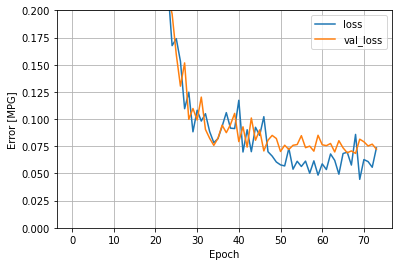

In [76]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Evaluate neural network

In [77]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.0723 - mse: 0.0723
loss test data:  0.07234267890453339
mse test data:  0.07234267890453339
4/4 [==============================] - 0s 2ms/step - loss: 0.0441 - mse: 0.0441
loss train data:  0.04411735385656357
mse train data:  0.04411735385656357


Plot results

<function matplotlib.pyplot.show>

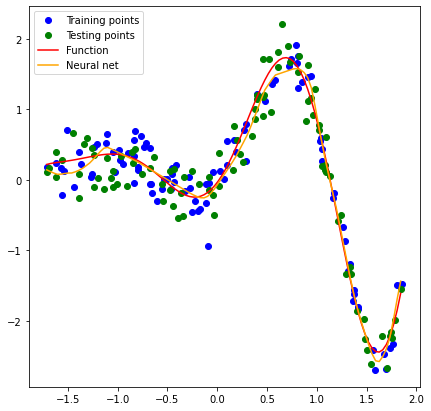

In [78]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-meany)/stdy,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')

#plt.plot(XX_train_n, model0.predict(XX_train_n), 'o',  color='red', label='NN')

plt.legend()


plt.show

**The Boston Housing Price dataset**

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset has very few data points, only 506 in total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, others between 0 and 100...

In [79]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()



**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [80]:
mean = X_train.mean(axis=0)
X_train_n = X_train-mean
std = X_train_n.std(axis=0)
X_train_n /= std

X_test_n = X_test - mean
X_test_n /= std

meany = y_train.mean(axis=0)
y_train_n = y_train - meany
stdy = y_train_n.std(axis=0)
y_train_n /= stdy

y_test_n = y_test - meany
y_test_n /= stdy



#XX_train_n = XX_train_n.reshape((len(XX_train_n),1))
#XX_test_n  = XX_test_n.reshape((len(XX_test_n),1))


In [81]:

model = Sequential()

# Keras model with two hidden layer with 10 neurons each 
model.add(Dense(8, input_shape = (X_train.shape[1],)))    # Input layer => input_shape should be explicitly designated
model.add(Activation('relu'))
#model.add(Dropout(0.01))
model.add(Dense(8))                         # Hidden layer => only output dimension should be designated
model.add(Activation('relu'))
#model.add(Dropout(0.01))
model.add(Dense(1))                          # Output layer => output dimension = 1 since it is regression problem


#sgd = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer

model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mse'])    # for regression problems, mean squared error (MSE) is often employed
history = model.fit(X_train_n, y_train_n, batch_size = 50, epochs = 200, verbose = 1, validation_data=(X_test_n,y_test_n))



Epoch 1/200
9/9 [==============================] - 0s 13ms/step - loss: 0.7392 - mse: 0.7392 - val_loss: 0.5729 - val_mse: 0.5729
Epoch 2/200
9/9 [==============================] - 0s 4ms/step - loss: 0.6624 - mse: 0.6624 - val_loss: 0.5332 - val_mse: 0.5332
Epoch 3/200
9/9 [==============================] - 0s 4ms/step - loss: 0.6164 - mse: 0.6164 - val_loss: 0.4933 - val_mse: 0.4933
Epoch 4/200
9/9 [==============================] - 0s 4ms/step - loss: 0.5758 - mse: 0.5758 - val_loss: 0.4714 - val_mse: 0.4714
Epoch 5/200
9/9 [==============================] - 0s 4ms/step - loss: 0.5396 - mse: 0.5396 - val_loss: 0.4405 - val_mse: 0.4405
Epoch 6/200
9/9 [==============================] - 0s 5ms/step - loss: 0.5012 - mse: 0.5012 - val_loss: 0.4247 - val_mse: 0.4247
Epoch 7/200
9/9 [==============================] - 0s 4ms/step - loss: 0.4704 - mse: 0.4704 - val_loss: 0.3948 - val_mse: 0.3948
Epoch 8/200
9/9 [==============================] - 0s 4ms/step - loss: 0.4437 - mse: 0.4437 - va

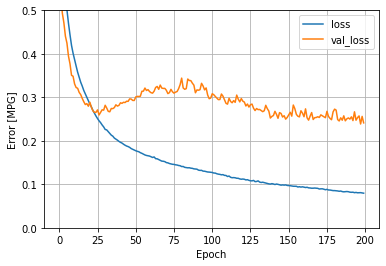

In [82]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


In [83]:
results = model.evaluate(X_test_n, y_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model.evaluate(X_train_n, y_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.2413 - mse: 0.2413
loss test data:  0.2413274049758911
mse test data:  0.2413274049758911
13/13 [==============================] - 0s 2ms/step - loss: 0.0790 - mse: 0.0790
loss train data:  0.07898592948913574
mse train data:  0.07898592948913574
